In [1]:
import sys
sys.path.append(r'/hr-fs02/hr_projekte/Pol-InSAR_InfoRetrieval/10_users/mans_is/PyPolSAR')

In [2]:
import rioxarray
import rasterio as rio
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import box, mapping
from scipy import ndimage
from pypolsar import geo
import pprint


In [3]:
import h5py

from pypolsar import polsar
import matplotlib.pyplot as plt

from pypolsar import utils, plot
from pypolsar import polsar
from pypolsar.polsar import decomposition

from pypolsar.stats.timer import Timer
from pathlib import Path
import pypolsar

import seaborn as sns
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap


In [4]:
fig_save = Path("./../figures/")

In [5]:
from pathlib import Path

process_path = Path('./../data/processed/')
# p = Path('./')
prmasr_nc = {}
prmasr_nc["L"] = {}
prmasr_nc["S"] = {}
prmasr_nc["L"]["18"] = sorted(list( process_path.glob('./ecological_masks/18*L.nc')))
prmasr_nc["L"]["19"] = sorted(list( process_path.glob('./ecological_masks/19*L.nc')))
prmasr_nc["S"]["18"] = sorted(list( process_path.glob('./ecological_masks/18*S.nc')))
prmasr_nc["S"]["19"] = sorted(list( process_path.glob('./ecological_masks/19*S.nc')))
prmasr_nc

{'L': {'18': [PosixPath('../data/processed/ecological_masks/18prmasr0302_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0303_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0304_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0305_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0306_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0307_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0308_L.nc')],
  '19': [PosixPath('../data/processed/ecological_masks/19prmasr1002_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1003_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1004_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1006_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1007_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1008_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1009_L.nc')]},


In [6]:

colors_hex = ["#4DB65B", "#425DAA", "#F1EB58", "#A4AA56", "#49B0AD", "#A95052", "#74C044"]
color_names = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove+Jae', 'Thrasher']

ecological_colors = {}
for name, color_hex in zip(color_names, colors_hex):
    ecological_colors[name] = matplotlib.colors.to_rgb(color_hex)
    
print(ecological_colors)


{'Avadlek': (0.30196078431372547, 0.7137254901960784, 0.3568627450980392), 'Guillemot': (0.25882352941176473, 0.36470588235294116, 0.6666666666666666), 'Herschel': (0.9450980392156862, 0.9215686274509803, 0.34509803921568627), 'Komakuk': (0.6431372549019608, 0.6666666666666666, 0.33725490196078434), 'Orca': (0.28627450980392155, 0.6901960784313725, 0.6784313725490196), 'Plove+Jae': (0.6627450980392157, 0.3137254901960784, 0.3215686274509804), 'Thrasher': (0.4549019607843137, 0.7529411764705882, 0.26666666666666666)}


In [7]:
def combine_netcdf(path_18, path_19, clip=None):
    ds_1 = xr.open_dataset(path_18)
    ds_2 = xr.open_dataset(path_19)

    ds_con = xr.concat([ds_1, ds_2], dim=pd.Index([2018, 2019], name='time'))
    ds_con = ds_con.where(ds_con.mask_valid == 1) 
    if clip is not None:
        ds_con = clip_raster_with_shp(ds_con, shapefile= shapefile_clip)
    
    return ds_con

def combine_netcdf_bands(path_18, path_19, clip=None):
    ds_1 = xr.open_dataset(path_18)
    ds_2 = xr.open_dataset(path_19)

    ds_con = xr.concat([ds_1, ds_2], dim='wavelength')
    ds_con = ds_con.where(ds_con.mask_valid == 1) 
    if clip is not None:
        ds_con = clip_raster_with_shp(ds_con, shapefile= shapefile_clip)
    
    return ds_con

In [8]:
ds_l = combine_netcdf(prmasr_nc["L"]["18"][1], prmasr_nc["L"]["19"][1])
ds_s = combine_netcdf(prmasr_nc["S"]["18"][1], prmasr_nc["S"]["19"][1])
ds_l["offnadir"] = np.rad2deg(ds_l["offnadir"])
ds_s["offnadir"] = np.rad2deg(ds_s["offnadir"])
ds_l["aoi"] = np.rad2deg(ds_l["aoi"])
ds_s["aoi"] = np.rad2deg(ds_s["aoi"])

In [14]:
ds_l

<xarray.Dataset>
Dimensions:          (band: 1, time: 2, x: 5470, y: 13530)
Coordinates:
    mask_valid       (time, y, x) int8 0 0 0 0 0 0 0 ... -15 -15 -15 -15 -15 -15
    mask_Avadlek     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Guillemot   (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Herschel    (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Komakuk     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Orca        (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Plove_+Jae  (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Thrasher    (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * y                (y) float64 7.727e+06 7.727e+06 ... 7.714e+06 7.714e+06
  * x                (x) float64 5.697e+05 5.697e+05 ... 5.752e+05 5.752e+05
  * band             (band) int32 1
    wavelength       (time, band) float64 0.2262 0.2262
    spatial_ref      int32 0
  * time             (time) int64 2018 2019
Data variables:
    offnadir         (time, band, y, x) float32 nan nan nan nan ... nan nan nan
    entropy          (time, band, y, x) float64 nan nan nan nan ... nan nan nan
    anisotropy       (time, band, y, x) float64 nan nan nan nan ... nan nan nan
    alpha            (time, band, y, x) float64 nan nan nan nan ... nan nan nan
    p_hhvv           (time, band, y, x) float32 nan nan nan nan ... nan nan nan
    ph_diff_hhvv     (time, band, y, x) float32 nan nan nan nan ... nan nan nan
    aoi              (time, band, y, x) float32 nan nan nan nan ... nan nan nan

In [16]:
df_masked = ds_l.where(ds_l['mask_Herschel'] == 1).to_dataframe()

In [19]:
df_masked_dropna = df_masked.dropna()
df_masked_dropna

offnadir   entropy  anisotropy  \
band time x             y                                               
1    2018 570017.822886 7.723698e+06  22.797363  0.427967    0.296807   
                        7.723697e+06  22.796772  0.426735    0.336659   
          570018.822886 7.723700e+06  22.810383  0.401885    0.227113   
                        7.723699e+06  22.809879  0.532011    0.176261   
                        7.723698e+06  22.809319  0.434673    0.316430   
...                                         ...       ...         ...   
     2019 575087.822886 7.714978e+06  56.890461  0.657367    0.574185   
                        7.714977e+06  56.890129  0.637871    0.540128   
                        7.714976e+06  56.889793  0.550450    0.522791   
                        7.714975e+06  56.889458  0.396786    0.472471   
                        7.714974e+06  56.889130  0.442466    0.538570   

                                          alpha    p_hhvv  ph_diff_hhvv  \
band time x             y                                                 
1    2018 570017.822886 7.723698e+06  19.792583  0.759275      9.050803   
                        7.723697e+06  22.852973  0.684825     10.859898   
          570018.822886 7.723700e+06  16.621316  0.942100     -7.476103   
                        7.723699e+06  21.654459  0.897151     -0.029181   
                        7.723698e+06  19.845599  0.761683      9.250571   
...                                         ...       ...           ...   
     2019 575087.822886 7.714978e+06  33.038889  0.693415     23.094009   
                        7.714977e+06  37.755502  0.820989     40.441086   
                        7.714976e+06  33.347112  0.696655     33.656193   
                        7.714975e+06  28.361838  0.587039     26.222532   
                        7.714974e+06  26.040633  0.639164     13.077965   

                                            aoi  mask_valid  mask_Avadlek  \
band time x             y                                                   
1    2018 570017.822886 7.723698e+06  21.129635           1             0   
                        7.723697e+06  21.128956           1             0   
          570018.822886 7.723700e+06  21.176111           1             0   
                        7.723699e+06  21.178421           1             0   
                        7.723698e+06  21.179407           1             0   
...                                         ...         ...           ...   
     2019 575087.822886 7.714978e+06  56.752010           1             0   
                        7.714977e+06  56.724068           1             0   
                        7.714976e+06  56.697193           1             0   
                        7.714975e+06  56.671211           1             0   
                        7.714974e+06  56.645802           1             0   

                                      mask_Guillemot  mask_Herschel  \
band time x             y                                             
1    2018 570017.822886 7.723698e+06               0              1   
                        7.723697e+06               1              1   
          570018.822886 7.723700e+06               0              1   
                        7.723699e+06               0              1   
                        7.723698e+06               0              1   
...                                              ...            ...   
     2019 575087.822886 7.714978e+06               0              1   
                        7.714977e+06               0              1   
                        7.714976e+06               0              1   
                        7.714975e+06               0              1   
                        7.714974e+06               0              1   

                                      mask_Komakuk  mask_Orca  \
band time x             y                                       
1    2018 570017.822886 7.723698e+06             0       

In [55]:
df_masked_dropna_2018 = df_masked_dropna.iloc[df_masked_dropna.index.get_level_values('time') == 2018]
df_masked_dropna_2019 = df_masked_dropna.iloc[df_masked_dropna.index.get_level_values('time') == 2019]


In [65]:
df_masked_dropna_2018_mean = create_mean_df(main_df=df_masked_dropna_2018, mean_by='aoi', n_bins=10000)
df_masked_dropna_2019_mean = create_mean_df(main_df=df_masked_dropna_2019, mean_by='aoi', n_bins=10000)


In [66]:
df_masked_dropna_2018_mean

offnadir         entropy       anisotropy            alpha  \
                       mean count      mean count       mean count       mean   
Bin                                                                             
(13.997, 14.05]   26.697531     1  0.138550     1   0.247463     1   7.198995   
(14.05, 14.054]         NaN     0       NaN     0        NaN     0        NaN   
(14.054, 14.059]        NaN     0       NaN     0        NaN     0        NaN   
(14.059, 14.064]        NaN     0       NaN     0        NaN     0        NaN   
(14.064, 14.069]        NaN     0       NaN     0        NaN     0        NaN   
...                     ...   ...       ...   ...        ...   ...        ...   
(61.503, 61.507]  56.854069     3  0.580316     3   0.407452     3  30.793246   
(61.507, 61.512]  56.851299     1  0.521960     1   0.221115     1  30.893625   
(61.512, 61.517]  56.851803     1  0.605996     1   0.373450     1  30.458522   
(61.517, 61.522]  56.851540     2  0.488377     2   0.332288     2  31.661963   
(61.522, 61.526]  56.851532     3  0.534487     3   0.388272     3  33.357789   

                          p_hhvv        ... mask_Orca       mask_Plove_+Jae  \
                 count      mean count  ...      mean count            mean   
Bin                                     ...                                   
(13.997, 14.05]      1  0.927778     1  ...       0.0     1             0.0   
(14.05, 14.054]      0       NaN     0  ...       NaN     0             NaN   
(14.054, 14.059]     0       NaN     0  ...       NaN     0             NaN   
(14.059, 14.064]     0       NaN     0  ...       NaN     0             NaN   
(14.064, 14.069]     0       NaN     0  ...       NaN     0             NaN   
...                ...       ...   ...  ...       ...   ...             ...   
(61.503, 61.507]     3  0.947425     3  ...       0.0     3             0.0   
(61.507, 61.512]     1  0.927967     1  ...       0.0     1             0.0   
(61.512, 61.517]     1  0.728543     1  ...       0.0     1             0.0   
(61.517, 61.522]     2  0.600345     2  ...       0.0     2             0.0   
(61.522, 61.526]     3  0.786065     3  ...       0.0     3             0.0   

                       mask_Thrasher       wavelength       spatial_ref        
                 count          mean count       mean count        mean count  
Bin                                                                            
(13.997, 14.05]      1           0.0     1   0.226208     1         0.0     1  
(14.05, 14.054]      0           NaN     0        NaN     0         NaN     0  
(14.054, 14.059]     0           NaN     0        NaN     0         NaN     0  
(14.059, 14.064]     0           NaN     0        NaN     0         NaN     0  
(14.064, 14.069]     0           NaN     0        NaN     0         NaN     0  
...                ...           ...   ...        ...   ...         ...   ...  
(61.503, 61.507]     3           0.0     3   0.226208     3         0.0     3  
(61.507, 61.512]     1           0.0     1   0.226208     1         0.0     1  
(61.512, 61.517]     1           0.0     1   0.226208     1         0.0     1  
(61.517, 61.522]     2           0.0     2   0.226208     2         0.0     2  
(61.522, 61.526]     3           0.0     3   0.226208     3         0.0     3  

[10000 rows x 34 columns]

In [67]:
df_masked_dropna_2019_mean

offnadir         entropy       anisotropy            alpha  \
                       mean count      mean count       mean count       mean   
Bin                                                                             
(18.524, 18.571]  22.194731     1  0.338396     1   0.682718     1  15.577526   
(18.571, 18.576]  22.212286     2  0.323193     2   0.672742     2  15.506678   
(18.576, 18.58]   22.229683     1  0.303786     1   0.661056     1  14.200111   
(18.58, 18.584]         NaN     0       NaN     0        NaN     0        NaN   
(18.584, 18.589]  22.241110     1  0.300367     1   0.647371     1  12.979421   
...                     ...   ...       ...   ...        ...   ...        ...   
(61.49, 61.494]   56.847900     3  0.331597     3   0.437354     3  13.329321   
(61.494, 61.499]  56.845230     1  0.219529     1   0.202505     1  12.443559   
(61.499, 61.503]  56.847225     4  0.364405     4   0.419068     4  18.602230   
(61.503, 61.507]  56.845432     2  0.441238     2   0.398891     2  24.125491   
(61.507, 61.511]  56.849007     4  0.380849     4   0.410264     4  20.490867   

                          p_hhvv        ... mask_Orca       mask_Plove_+Jae  \
                 count      mean count  ...      mean count            mean   
Bin                                     ...                                   
(18.524, 18.571]     1  0.671790     1  ...       0.0     1             0.0   
(18.571, 18.576]     2  0.652516     2  ...       0.0     2             0.0   
(18.576, 18.58]      1  0.669675     1  ...       0.0     1             0.0   
(18.58, 18.584]      0       NaN     0  ...       NaN     0             NaN   
(18.584, 18.589]     1  0.716309     1  ...       0.0     1             0.0   
...                ...       ...   ...  ...       ...   ...             ...   
(61.49, 61.494]      3  0.905493     3  ...       0.0     3             0.0   
(61.494, 61.499]     1  1.006213     1  ...       0.0     1             0.0   
(61.499, 61.503]     4  0.916888     4  ...       0.0     4             0.0   
(61.503, 61.507]     2  0.782209     2  ...       0.0     2             0.0   
(61.507, 61.511]     4  0.894740     4  ...       0.0     4             0.0   

                       mask_Thrasher       wavelength       spatial_ref        
                 count          mean count       mean count        mean count  
Bin                                                                            
(18.524, 18.571]     1           0.0     1   0.226195     1         0.0     1  
(18.571, 18.576]     2           0.0     2   0.226195     2         0.0     2  
(18.576, 18.58]      1           0.0     1   0.226195     1         0.0     1  
(18.58, 18.584]      0           NaN     0        NaN     0         NaN     0  
(18.584, 18.589]     1           0.0     1   0.226195     1         0.0     1  
...                ...           ...   ...        ...   ...         ...   ...  
(61.49, 61.494]      3           0.0     3   0.226195     3         0.0     3  
(61.494, 61.499]     1           0.0     1   0.226195     1         0.0     1  
(61.499, 61.503]     4           0.0     4   0.226195     4         0.0     4  
(61.503, 61.507]     2           0.0     2   0.226195     2         0.0     2  
(61.507, 61.511]     4           0.0     4   0.226195     4         0.0     4  

[10000 rows x 34 columns]

In [79]:
def create_mean_df(df_masked_mean, UnitName, Band):
    offnadir_mean = df_masked_mean['offnadir']['mean'].values
    aoi_mean = df_masked_mean['aoi']['mean'].values
    entropy_mean = df_masked_mean['entropy']['mean'].values
    alpha_mean = df_masked_mean['alpha']['mean'].values
    p_hhvv_mean = df_masked_mean['p_hhvv']['mean'].values
    ph_diff_hhvv_mean = df_masked_mean['ph_diff_hhvv']['mean'].values
    anisotropy_mean = df_masked_mean['anisotropy']['mean'].values
    df_tmp = pd.DataFrame(
        [(UnitName, aoi_mean, offnadir_mean, entropy_mean, alpha_mean, p_hhvv_mean, anisotropy_mean, ph_diff_hhvv_mean, Band)],
        columns=["UnitName", 'aoi', "offnadir", "entropy", "alpha", 'p_hhvv', 'anisotropy', 'ph_diff_hhvv', 'band'])
    df_tmp = df_tmp.apply(pd.Series.explode).reset_index()
    return df_tmp.dropna()


create_mean_df(df_masked_dropna_2018_mean, UnitName='Test', Band='L')

,index,UnitName,aoi,offnadir,entropy,alpha,p_hhvv,anisotropy,ph_diff_hhvv,band
0,0,Test,14.0449,26.6975,0.13855,7.199,0.927778,0.247463,-1.99829,L
369,0,Test,15.7976,27.3154,0.316184,15.9206,0.711195,0.164437,5.34179,L
468,0,Test,16.2713,31.139,0.370035,15.6001,1.1527,0.413798,-1.27793,L
690,0,Test,17.3247,27.4162,0.343781,13.5954,1.09607,0.687751,9.72934,L
702,0,Test,17.3819,31.089,0.312371,17.5312,0.613112,0.753996,5.84787,L
...,...,...,...,...,...,...,...,...,...,...
9995,0,Test,61.5045,56.8541,0.580316,30.7932,0.947425,0.407452,27.0959,L
9996,0,Test,61.5115,56.8513,0.52196,30.8936,0.927967,0.221115,39.1206,L
9997,0,Test,61.5136,56.8518,0.605996,30.4585,0.728543,0.37345,19.3201,L
9998,0,Test,61.5202,56.8515,0.488377,31.662,0.600345,0.332288,30.3002,L


In [82]:
def create_mean_along_dim(main_df, mean_by='aoi', n_bins=1000):
    main_df_mean = (main_df
      .assign(Bin=lambda x: pd.cut(x[mean_by], bins=n_bins))
      .groupby(['Bin'])
      .agg(['mean', 'count'])
     )
    
    return main_df_mean


def create_mean_df(df_masked_mean, UnitName, Band):
    offnadir_mean = df_masked_mean['offnadir']['mean'].values
    aoi_mean = df_masked_mean['aoi']['mean'].values
    entropy_mean = df_masked_mean['entropy']['mean'].values
    alpha_mean = df_masked_mean['alpha']['mean'].values
    p_hhvv_mean = df_masked_mean['p_hhvv']['mean'].values
    ph_diff_hhvv_mean = df_masked_mean['ph_diff_hhvv']['mean'].values
    anisotropy_mean = df_masked_mean['anisotropy']['mean'].values
    df_tmp = pd.DataFrame(
        [(UnitName, aoi_mean, offnadir_mean, entropy_mean, alpha_mean, p_hhvv_mean, anisotropy_mean, ph_diff_hhvv_mean, Band)],
        columns=["UnitName", 'aoi', "offnadir", "entropy", "alpha", 'p_hhvv', 'anisotropy', 'ph_diff_hhvv', 'band'])
    df_tmp = df_tmp.apply(pd.Series.explode).reset_index()
    return df_tmp.dropna()
    

def create_mean_dataframes(path_L_18, path_L_19, path_S_18, path_S_19):
    ds_l = combine_netcdf(path_L_18 , path_L_19)
    ds_s = combine_netcdf(path_S_18, path_S_19)
    ds_l["offnadir"] = np.rad2deg(ds_l["offnadir"])
    ds_s["offnadir"] = np.rad2deg(ds_s["offnadir"])
    ds_l["aoi"] = np.rad2deg(ds_l["aoi"])
    ds_s["aoi"] = np.rad2deg(ds_s["aoi"])


    unit_masks = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove_+Jae', 'Thrasher']
    unit_names = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove+Jae', 'Thrasher']
    df_18_mean = pd.DataFrame([], columns=["UnitName", 'aoi', "offnadir", "entropy", "alpha", 'p_hhvv', 'anisotropy', 'ph_diff_hhvv', 'band'])
    df_19_mean = pd.DataFrame([], columns=["UnitName", 'aoi', "offnadir", "entropy", "alpha", 'p_hhvv', 'anisotropy', 'ph_diff_hhvv', 'band'])

    for UnitName, UnitMask in zip(unit_names, unit_masks):
        print(UnitName)
        ## mask and create dataframe L- Band
        df_L = ds_l.where(ds_l['mask_'+UnitMask] == 1).to_dataframe().dropna()
        df_S = ds_s.where(ds_s['mask_'+UnitMask] == 1).to_dataframe().dropna()

        ################
        df_masked_L_2018 = df_L.iloc[df_L.index.get_level_values('time') == 2018]
        df_masked_L_2019 = df_L.iloc[df_L.index.get_level_values('time') == 2019]
        df_masked_S_2018 = df_S.iloc[df_S.index.get_level_values('time') == 2018]
        df_masked_S_2019 = df_S.iloc[df_S.index.get_level_values('time') == 2019]

        #########
        df_masked_L_mean_2018 = create_mean_along_dim(main_df=df_masked_L_2018, mean_by='aoi', n_bins=10000)
        df_masked_L_mean_2019 = create_mean_along_dim(main_df=df_masked_L_2019, mean_by='aoi', n_bins=10000)
        df_masked_S_mean_2018 = create_mean_along_dim(main_df=df_masked_S_2018, mean_by='aoi', n_bins=10000)
        df_masked_S_mean_2019 = create_mean_along_dim(main_df=df_masked_S_2019, mean_by='aoi', n_bins=10000)

        ################
        df_mean_L_2018 = create_mean_df(df_masked_L_mean_2018, UnitName, Band='L')
        df_mean_L_2019 = create_mean_df(df_masked_L_mean_2019, UnitName, Band='L')
        df_mean_S_2018 = create_mean_df(df_masked_S_mean_2018, UnitName, Band='S')
        df_mean_S_2019 = create_mean_df(df_masked_S_mean_2019, UnitName, Band='S')


        ################
        df_18_mean = df_18_mean.append(df_mean_L_2018)
        df_18_mean = df_18_mean.append(df_mean_S_2018)
        
        df_19_mean = df_19_mean.append(df_mean_L_2019)
        df_19_mean = df_19_mean.append(df_mean_S_2019)
        
    return df_18_mean, df_19_mean


process_range_profile_mean()

In [184]:
diff_entropy = ds_l.where((ds_l['mask_'+UnitMask] == 1)).isel(time=[0])['entropy'].data - ds_l.where((ds_l['mask_'+UnitMask] == 1)).isel(time=[1])['entropy'].data
diff_anisotropy = ds_l.where((ds_l['mask_'+UnitMask] == 1)).isel(time=[0])['anisotropy'].data - ds_l.where((ds_l['mask_'+UnitMask] == 1)).isel(time=[1])['anisotropy'].data
diff_alpha = ds_l.where((ds_l['mask_'+UnitMask] == 1)).isel(time=[0])['alpha'].data - ds_l.where((ds_l['mask_'+UnitMask] == 1)).isel(time=[1])['alpha'].data
diff_p_hhvv = ds_l.where((ds_l['mask_'+UnitMask] == 1)).isel(time=[0])['p_hhvv'].data - ds_l.where((ds_l['mask_'+UnitMask] == 1)).isel(time=[1])['p_hhvv'].data
diff_ph_diff_hhvv = ds_l.where((ds_l['mask_'+UnitMask] == 1)).isel(time=[0])['ph_diff_hhvv'].data - ds_l.where((ds_l['mask_'+UnitMask] == 1)).isel(time=[1])['ph_diff_hhvv'].data

diff_aoi = ds_l.where((ds_l['mask_'+UnitMask] == 1)).isel(time=[0])['aoi'].data
diff_offnadir = ds_l.where((ds_l['mask_'+UnitMask] == 1)).isel(time=[0])['offnadir'].data






ValueError: 7 columns passed, passed data had 74009100 columns

In [188]:
def create_diff_dataframe_from_xarray(ds_time):
    
    diff_entropy = ds_time.isel(time=[0])['entropy'].data - ds_time.isel(time=[1])['entropy'].data
    diff_anisotropy = ds_time.isel(time=[0])['anisotropy'].data - ds_time.isel(time=[1])['anisotropy'].data
    diff_alpha = ds_time.isel(time=[0])['alpha'].data - ds_time.isel(time=[1])['alpha'].data
    diff_p_hhvv = ds_time.isel(time=[0])['p_hhvv'].data - ds_time.isel(time=[1])['p_hhvv'].data
    diff_ph_diff_hhvv = ds_time.isel(time=[0])['ph_diff_hhvv'].data - ds_time.isel(time=[1])['ph_diff_hhvv'].data

    diff_aoi = ds_time.isel(time=[0])['aoi'].data
    diff_offnadir = ds_time.isel(time=[0])['offnadir'].data


    df_masked_diff = pd.DataFrame([], 
                                columns=['aoi', "offnadir", "entropy", "alpha", 'p_hhvv', 'anisotropy', 'ph_diff_hhvv']).dropna()
    df_masked_diff['aoi'] = diff_aoi.flatten()
    df_masked_diff['offnadir'] = diff_offnadir.flatten()
    df_masked_diff['entropy'] = diff_entropy.flatten()
    df_masked_diff['alpha'] = diff_alpha.flatten()
    df_masked_diff['p_hhvv'] = diff_p_hhvv.flatten()
    df_masked_diff['anisotropy'] = diff_anisotropy.flatten()
    df_masked_diff['ph_diff_hhvv'] = diff_ph_diff_hhvv.flatten()
    
    return df_masked_diff.dropna()

create_diff_dataframe_from_xarray(ds_time=ds_l.where(ds_l['mask_'+UnitMask] == 1))

,aoi,offnadir,entropy,alpha,p_hhvv,anisotropy,ph_diff_hhvv
3127386,52.532558,52.507935,0.367586,24.422809,-0.033766,0.147643,-25.653992
3127387,52.521797,52.512833,0.203726,21.825594,-0.393301,0.163437,-30.423386
3127388,52.502201,52.517727,-0.054408,15.780627,-0.647732,0.307025,-2.353570
3127389,52.478668,52.522640,-0.105225,18.405822,-0.762015,0.430707,4.759454
3127390,52.446644,52.527554,-0.185483,17.401633,-0.713584,0.303383,-2.591193
...,...,...,...,...,...,...,...
70172156,43.682899,44.061874,-0.041346,18.873875,-0.688402,0.219545,2.359401
70172157,43.711815,44.068771,-0.032582,19.365075,-0.674354,0.184459,2.932303
70172158,43.741264,44.075634,-0.041999,18.380924,-0.613605,0.214043,2.101656
70177625,43.655273,44.054665,-0.169397,15.251623,-0.741095,-0.078798,3.538132


In [185]:

df_masked_L_diff = pd.DataFrame([], 
                                columns=['aoi', "offnadir", "entropy", "alpha", 'p_hhvv', 'anisotropy', 'ph_diff_hhvv']).dropna()
df_masked_L_diff['aoi'] = diff_aoi.flatten()
df_masked_L_diff['offnadir'] = diff_offnadir.flatten()
df_masked_L_diff['entropy'] = diff_entropy.flatten()
df_masked_L_diff['alpha'] = diff_alpha.flatten()
df_masked_L_diff['p_hhvv'] = diff_p_hhvv.flatten()
df_masked_L_diff['anisotropy'] = diff_anisotropy.flatten()
df_masked_L_diff['ph_diff_hhvv'] = diff_ph_diff_hhvv.flatten()

In [187]:
df_masked_L_diff.dropna()

,aoi,offnadir,entropy,alpha,p_hhvv,anisotropy,ph_diff_hhvv
3127386,52.532558,52.507935,0.367586,24.422809,-0.033766,0.147643,-25.653992
3127387,52.521797,52.512833,0.203726,21.825594,-0.393301,0.163437,-30.423386
3127388,52.502201,52.517727,-0.054408,15.780627,-0.647732,0.307025,-2.353570
3127389,52.478668,52.522640,-0.105225,18.405822,-0.762015,0.430707,4.759454
3127390,52.446644,52.527554,-0.185483,17.401633,-0.713584,0.303383,-2.591193
...,...,...,...,...,...,...,...
70172156,43.682899,44.061874,-0.041346,18.873875,-0.688402,0.219545,2.359401
70172157,43.711815,44.068771,-0.032582,19.365075,-0.674354,0.184459,2.932303
70172158,43.741264,44.075634,-0.041999,18.380924,-0.613605,0.214043,2.101656
70177625,43.655273,44.054665,-0.169397,15.251623,-0.741095,-0.078798,3.538132


In [ ]:
df_masked_L_diff

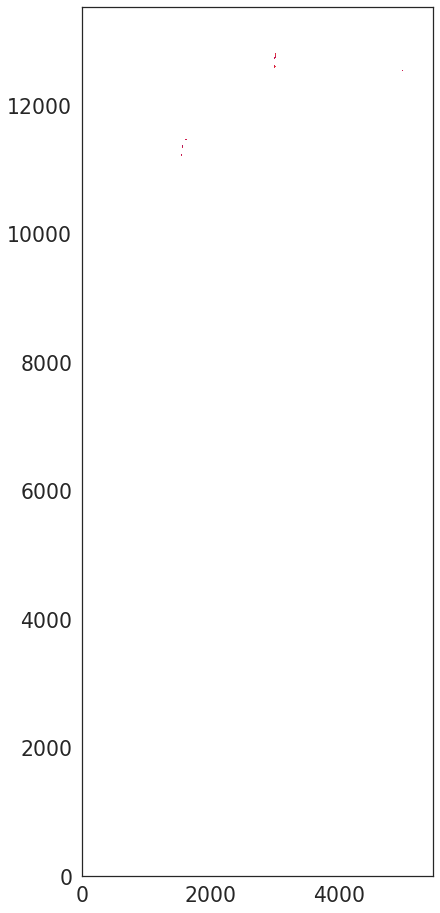

In [183]:
plt.imshow(diff_entropy[0,0,:,:])

In [ ]:
(ds_l_1.isel(time=[0]) - ds_l_1.isel(time=[1]) )['aoi']



In [176]:
UnitMask='Avadlek'
ds_l.where(ds_l['mask_'+UnitMask] == 1).isel(time=[0])-ds_l.where(ds_l['mask_'+UnitMask] == 1).isel(time=[1])

<xarray.Dataset>
Dimensions:          (band: 1, time: 0, x: 5470, y: 13530)
Coordinates:
  * time             (time) int64 
    mask_valid       (time, y, x) int8 
    mask_Avadlek     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Guillemot   (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Herschel    (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Komakuk     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Orca        (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Plove_+Jae  (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Thrasher    (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * y                (y) float64 7.727e+06 7.727e+06 ... 7.714e+06 7.714e+06
  * x                (x) float64 5.697e+05 5.697e+05 ... 5.752e+05 5.752e+05
  * band             (band) int32 1
    wavelength       (time, band) float64 
    spatial_ref      int32 0
Data variables:
    offnadir         (time, band, y, x) float32 
    entropy          (time, band, y, x) float64 
    anisotropy       (time, band, y, x) float64 
    alpha            (time, band, y, x) float64 
    p_hhvv           (time, band, y, x) float32 
    ph_diff_hhvv     (time, band, y, x) float32 
    aoi              (time, band, y, x) float32

In [ ]:
def create_mean_and_diff_dataframes(path_L_18, path_L_19, path_S_18, path_S_19):
    ds_l = combine_netcdf(path_L_18 , path_L_19)
    ds_s = combine_netcdf(path_S_18, path_S_19)
    ds_l["offnadir"] = np.rad2deg(ds_l["offnadir"])
    ds_s["offnadir"] = np.rad2deg(ds_s["offnadir"])
    ds_l["aoi"] = np.rad2deg(ds_l["aoi"])
    ds_s["aoi"] = np.rad2deg(ds_s["aoi"])


    unit_masks = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove_+Jae', 'Thrasher']
    unit_names = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove+Jae', 'Thrasher']
    df_18_mean = pd.DataFrame([], columns=["UnitName", 'aoi', "offnadir", "entropy", "alpha", 'p_hhvv', 'anisotropy', 'ph_diff_hhvv', 'band'])
    df_19_mean = pd.DataFrame([], columns=["UnitName", 'aoi', "offnadir", "entropy", "alpha", 'p_hhvv', 'anisotropy', 'ph_diff_hhvv', 'band'])

    for UnitName, UnitMask in zip(unit_names, unit_masks):
        print(UnitName)
        ## mask and create dataframe L- Band
        df_L = ds_l.where(ds_l['mask_'+UnitMask] == 1).to_dataframe().dropna()
        df_S = ds_s.where(ds_s['mask_'+UnitMask] == 1).to_dataframe().dropna()
        

        ################
        df_masked_L_2018 = df_L.iloc[df_L.index.get_level_values('time') == 2018]
        df_masked_L_2019 = df_L.iloc[df_L.index.get_level_values('time') == 2019]
        df_masked_S_2018 = df_S.iloc[df_S.index.get_level_values('time') == 2018]
        df_masked_S_2019 = df_S.iloc[df_S.index.get_level_values('time') == 2019]

        #########
        df_masked_L_mean_2018 = create_mean_along_dim(main_df=df_masked_L_2018, mean_by='aoi', n_bins=10000)
        df_masked_L_mean_2019 = create_mean_along_dim(main_df=df_masked_L_2019, mean_by='aoi', n_bins=10000)
        df_masked_S_mean_2018 = create_mean_along_dim(main_df=df_masked_S_2018, mean_by='aoi', n_bins=10000)
        df_masked_S_mean_2019 = create_mean_along_dim(main_df=df_masked_S_2019, mean_by='aoi', n_bins=10000)

        ################
        df_mean_L_2018 = create_mean_df(df_masked_L_mean_2018, UnitName, Band='L')
        df_mean_L_2019 = create_mean_df(df_masked_L_mean_2019, UnitName, Band='L')
        df_mean_S_2018 = create_mean_df(df_masked_S_mean_2018, UnitName, Band='S')
        df_mean_S_2019 = create_mean_df(df_masked_S_mean_2019, UnitName, Band='S')


        ################
        df_18_mean = df_18_mean.append(df_mean_L_2018)
        df_18_mean = df_18_mean.append(df_mean_S_2018)
        
        df_19_mean = df_19_mean.append(df_mean_L_2019)
        df_19_mean = df_19_mean.append(df_mean_S_2019)
        
    return df_18_mean, df_19_mean

In [83]:
dfmean_18, df_mean19 = create_mean_dataframes(path_L_18=prmasr_nc["L"]["18"][1], path_L_19= prmasr_nc["L"]["19"][1], 
                       path_S_18=prmasr_nc["S"]["18"][1], path_S_19=prmasr_nc["S"]["19"][1])

Avadlek
Guillemot
Herschel
Komakuk
Orca
Plove+Jae
Thrasher


In [101]:
ds_l_1 = combine_netcdf(prmasr_nc["L"]["18"][1] , prmasr_nc["L"]["19"][1])

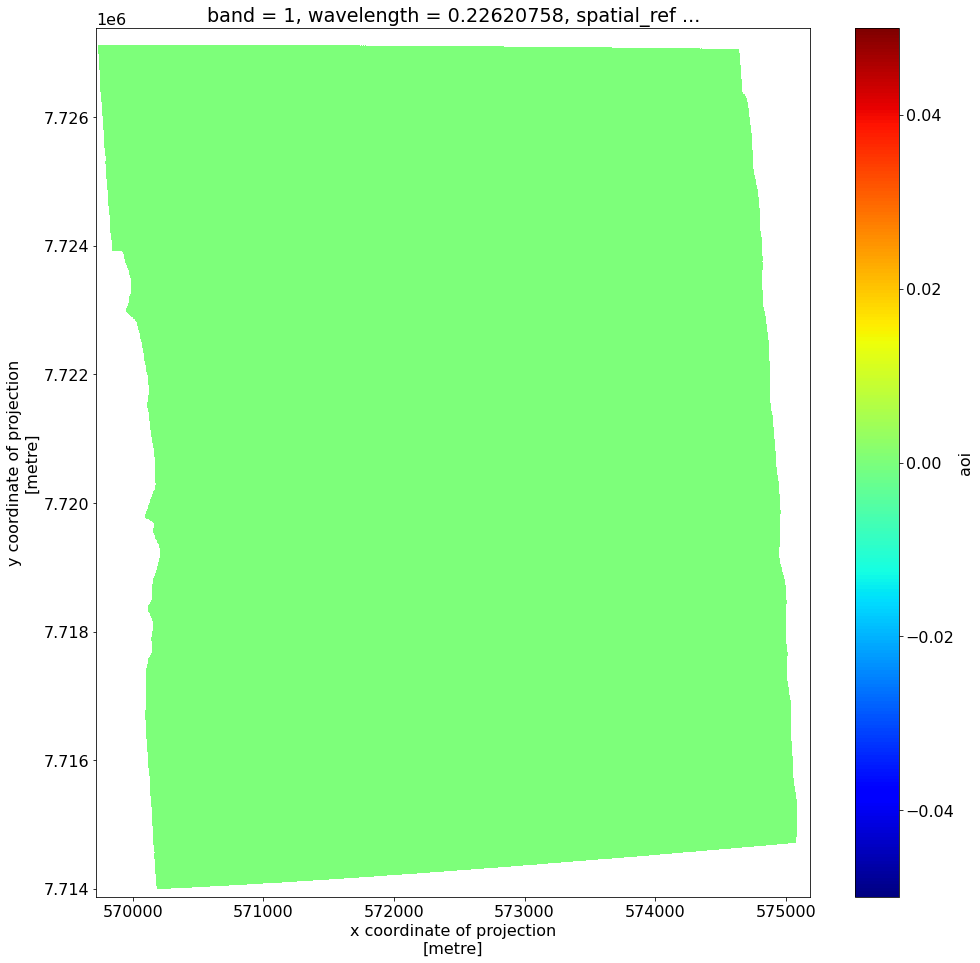

In [114]:
np.rad2deg((ds_l_1.isel(time=[0]) - ds_l_1.isel(time=[1]) )['aoi']).plot(cmap="jet")

/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/matplotlib/image.py:477: UserWarning: Warning: converting a masked element to nan.
  vrange = np.array([self.norm.vmin, self.norm.vmax],


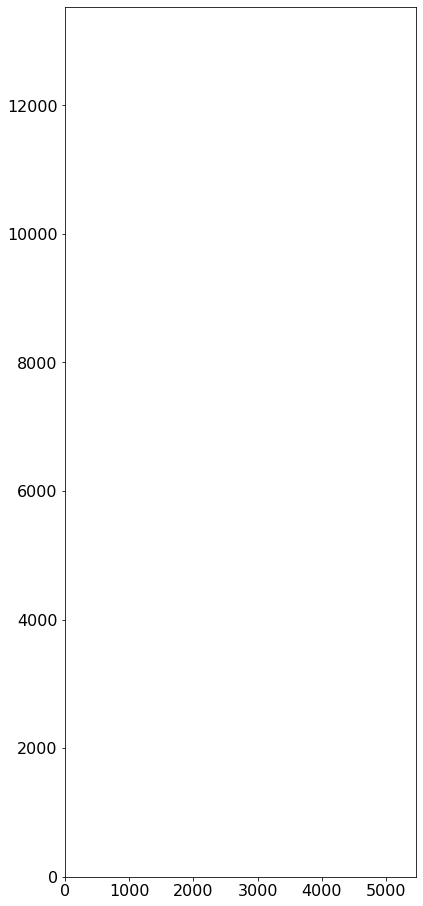

In [105]:
plt.imshow((ds_l_1['aoi'].where(ds_l_1.time == 2019).data - ds_l_1['aoi'].where(ds_l_1.time == 2018).data)[0,0,:,:])

In [88]:
dfmean_18

,UnitName,aoi,offnadir,entropy,alpha,p_hhvv,anisotropy,ph_diff_hhvv,band,index
0,Avadlek,29.4817,32.7605,0.236671,9.39667,0.842684,0.374143,2.11977,L,0.0
2,Avadlek,29.4882,32.7517,0.271211,14.7106,1.21851,0.515049,16.6428,L,0.0
21,Avadlek,29.5382,32.7601,0.265981,10.1951,0.757867,0.456333,2.36248,L,0.0
22,Avadlek,29.5404,32.7512,0.27638,12.5005,1.03528,0.309321,11.086,L,0.0
26,Avadlek,29.5489,32.769,0.299819,9.32672,1.00725,0.107054,-3.99613,L,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,Thrasher,89.4104,56.6715,0.496448,41.9588,0.237278,0.48235,8.95183,S,0.0
9996,Thrasher,89.4187,56.5194,0.711477,52.2087,0.436726,0.472536,-25.8424,S,0.0
9997,Thrasher,89.426,56.432,0.736837,50.3429,0.465445,0.51968,25.1984,S,0.0
9998,Thrasher,89.4331,56.427,0.767581,50.5747,0.516101,0.468618,40.4694,S,0.0


In [98]:
df_mean19

,UnitName,aoi,offnadir,entropy,alpha,p_hhvv,anisotropy,ph_diff_hhvv,band,index
0,Avadlek,29.5143,32.7171,0.229328,11.5041,0.704214,0.380276,-2.74808,L,0.0
21,Avadlek,29.5707,32.7123,0.292538,10.1226,0.865668,0.301626,1.78895,L,0.0
23,Avadlek,29.5758,32.721,0.20654,13.7434,0.544467,0.406378,-8.15115,L,0.0
25,Avadlek,29.58,32.7036,0.219978,8.07246,0.989102,0.432991,-2.07898,L,0.0
30,Avadlek,29.5918,32.7298,0.279324,12.5168,0.726449,0.512531,-4.3153,L,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,Thrasher,89.371,56.6132,0.769105,52.6732,0.963634,0.437643,-20.1659,S,0.0
9996,Thrasher,89.3772,56.6405,0.756546,53.6981,0.745292,0.519361,-6.13686,S,0.0
9997,Thrasher,89.3858,56.5313,0.83112,60.1547,0.56972,0.372425,68.4957,S,0.0
9998,Thrasher,89.3945,56.6663,0.713303,55.7021,0.379318,0.59429,66.2734,S,0.0


In [96]:
pd.concat([dfmean_18, df_mean19])

,UnitName,aoi,offnadir,entropy,alpha,p_hhvv,anisotropy,ph_diff_hhvv,band,index
0,Avadlek,29.4817,32.7605,0.236671,9.39667,0.842684,0.374143,2.11977,L,0.0
2,Avadlek,29.4882,32.7517,0.271211,14.7106,1.21851,0.515049,16.6428,L,0.0
21,Avadlek,29.5382,32.7601,0.265981,10.1951,0.757867,0.456333,2.36248,L,0.0
22,Avadlek,29.5404,32.7512,0.27638,12.5005,1.03528,0.309321,11.086,L,0.0
26,Avadlek,29.5489,32.769,0.299819,9.32672,1.00725,0.107054,-3.99613,L,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,Thrasher,89.371,56.6132,0.769105,52.6732,0.963634,0.437643,-20.1659,S,0.0
9996,Thrasher,89.3772,56.6405,0.756546,53.6981,0.745292,0.519361,-6.13686,S,0.0
9997,Thrasher,89.3858,56.5313,0.83112,60.1547,0.56972,0.372425,68.4957,S,0.0
9998,Thrasher,89.3945,56.6663,0.713303,55.7021,0.379318,0.59429,66.2734,S,0.0


Text(0.5, 0.98, '18prmasr0303_L 18prmasr0303_S')

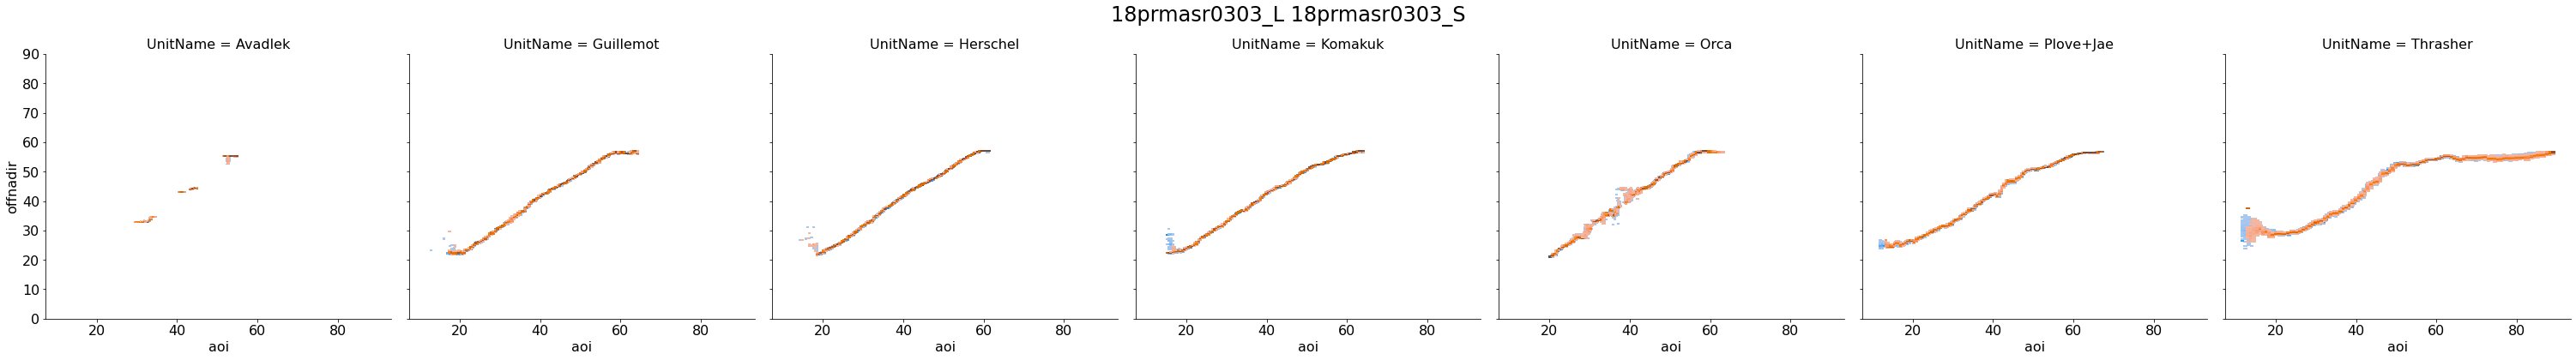

In [95]:
g = sns.FacetGrid(data=dfmean_18, col="UnitName", hue="band", height=6, ylim=(0, 90), 
                  ) 
g.map(sns.histplot, "aoi", "offnadir", bins=100)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle(prmasr_nc["L"]["18"][1].name[:-3] + " " + prmasr_nc["S"]["18"][1].name[:-3],
                  fontsize=24, fontdict={"weight": "bold"})

No handles with labels found to put in legend.


"\n\n\n# The color cycles are going to all the same, doesn't matter which axes we use\nAx = g.axes[0]\n\n# Some how for a plot of 5 bars, there are 6 patches, what is the 6th one?\nBoxes = [item for item in Ax.get_children()\n         if isinstance(item, matplotlib.patches.Rectangle)][:-1]\n\n# There is no labels, need to define the labels\nlegend_labels  = ['L', 'S',]\n\n# Create the legend patches\nlegend_patches = [matplotlib.patches.Patch(color=C, label=L) for\n                  C, L in zip([item.get_facecolor() for item in Boxes],\n                              legend_labels)]\n\n# Plot the legend\nplt.legend(handles=legend_patches)\n"

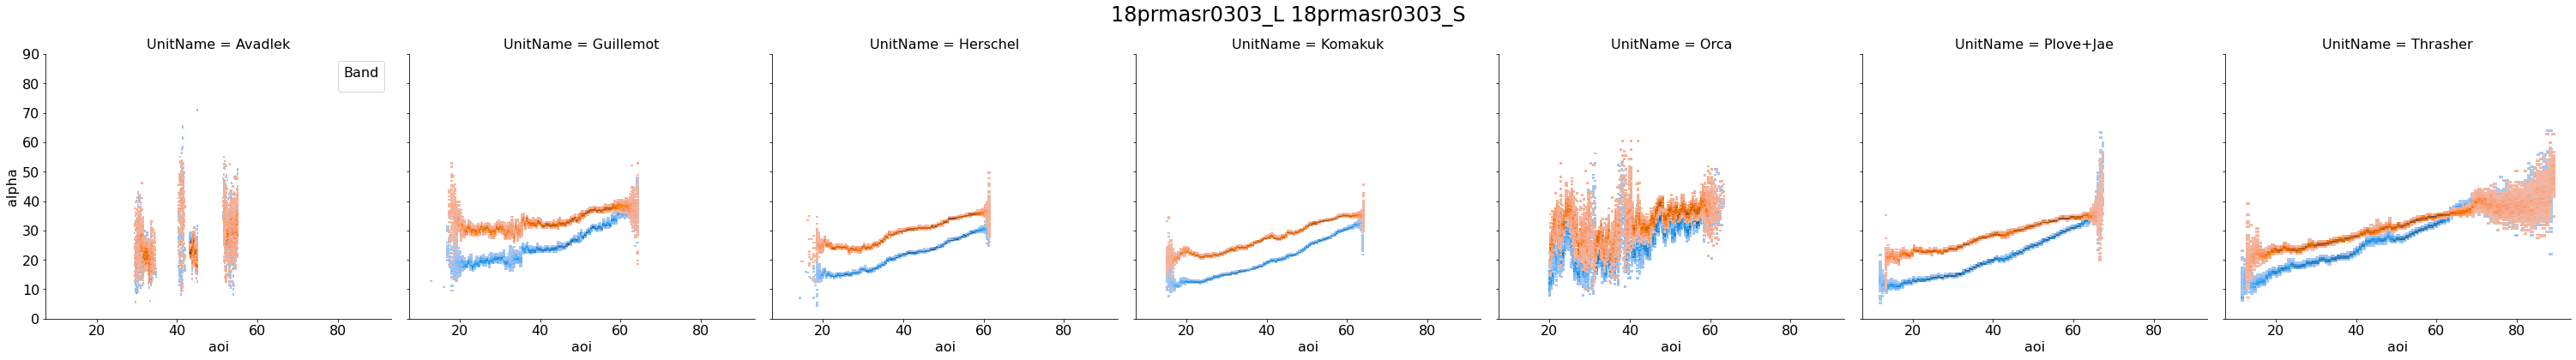

In [147]:
g = sns.FacetGrid(data=dfmean_18, col="UnitName", hue="band", height=6, ylim=(0, 90), 
                  ) 
g.map(sns.histplot, "aoi", "alpha", bins=100)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle(prmasr_nc["L"]["18"][1].name[:-3] + " " + prmasr_nc["S"]["18"][1].name[:-3],
                  fontsize=24, fontdict={"weight": "bold"})
g.axes[0, 0].legend(title="Band")

'''


# The color cycles are going to all the same, doesn't matter which axes we use
Ax = g.axes[0]

# Some how for a plot of 5 bars, there are 6 patches, what is the 6th one?
Boxes = [item for item in Ax.get_children()
         if isinstance(item, matplotlib.patches.Rectangle)][:-1]

# There is no labels, need to define the labels
legend_labels  = ['L', 'S',]

# Create the legend patches
legend_patches = [matplotlib.patches.Patch(color=C, label=L) for
                  C, L in zip([item.get_facecolor() for item in Boxes],
                              legend_labels)]

# Plot the legend
plt.legend(handles=legend_patches)
'''

In [148]:
g.axes[0,0].get_color()

AttributeError: 'AxesSubplot' object has no attribute 'get_color'

In [129]:
def plot_2dhist_range_profile():
    latex_label = {'entropy': 'Entropy (${H}_w$)', 
               'offnadir': 'offnadir [deg]',
               'anisotropy': 'Anisotropy (${H}_w$)', 
               'alpha': 'Alpha (${\\alpha}_{avg}$) [deg]',
               'p_hhvv': '${P}_{HHVV}$',
               'ph_diff_hhvv': 'CPD ${Phase}_{HHVV}$ [deg]',
               'aoi': 'AOI [deg]',}
    
    
    g = sns.FacetGrid(data=dfmean_18, col="UnitName", hue="band", height=6, ylim=(0, 1), 
                  ) 
g.map_dataframe(sns.histplot, "aoi", "entropy", bins=100, )

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle(prmasr_nc["L"]["18"][1].name[:-3] + " " + prmasr_nc["S"]["18"][1].name[:-3],
                  fontsize=24, fontdict={"weight": "bold"})


legend_name  = ['L-Band', 'S-Band',]
LegendElement = {}
LegendElement[legend_name[0]] = mpatches.Patch(color=sns.color_palette("tab10",2)[0], label=legend_name[0])
LegendElement[legend_name[1]] = mpatches.Patch(color=sns.color_palette("tab10",2)[1], label=legend_name[1])

legend_items = []

[legend_items.append(x) for x in list(dict(sorted(LegendElement.items())).values())]



g.add_legend(title="Band", handles=legend_items )

/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


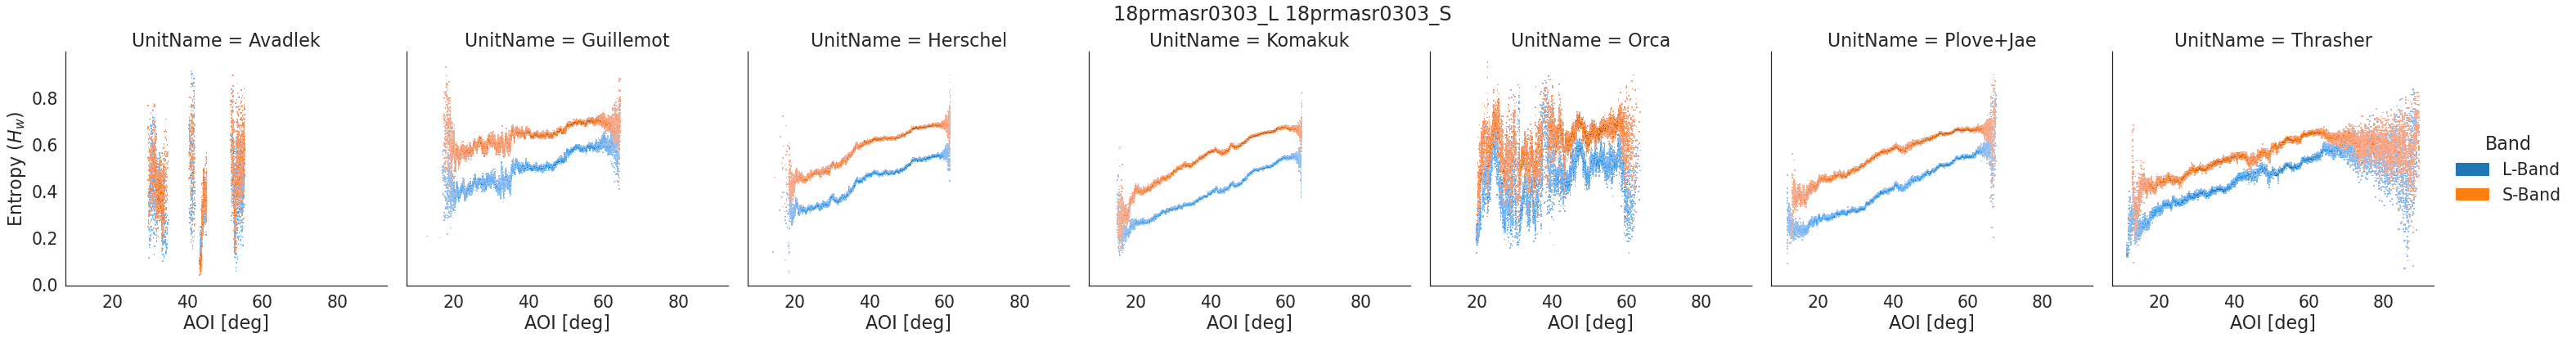

In [170]:
def plot_2dhist_sns_range_profile(df, col='UnitName', hue="band", x_hist='aoi', 
                    y_hist='entropy', suptitle=None, x_y_label_dict=None, 
                    xlim=None, ylim=None):
    sns.set(font_scale=1.85)  # crazy big
    sns.set_style("white")

    g = sns.FacetGrid(df, col=col, height=6, aspect=1, 
                      hue="band", palette=sns.color_palette("tab10",2), 
                      xlim=xlim, ylim=ylim)
    g.map(sns.histplot, x_hist, y_hist, bins=300, )
    if x_y_label_dict is not None :
        g.set_axis_labels(x_y_label_dict[x_hist], x_y_label_dict[y_hist])
        
    legend_name  = ['L-Band', 'S-Band',]
    LegendElement = {}
    LegendElement[legend_name[0]] = mpatches.Patch(color=sns.color_palette("tab10",2)[0], label=legend_name[0])
    LegendElement[legend_name[1]] = mpatches.Patch(color=sns.color_palette("tab10",2)[1], label=legend_name[1])

    legend_items = []

    [legend_items.append(x) for x in list(dict(sorted(LegendElement.items())).values())]



    g.add_legend(title="Band", handles=legend_items )
    if suptitle is not None:
        g.fig.subplots_adjust(top=0.85)
        g.fig.suptitle(suptitle,
                      fontsize=24, fontdict={"weight": "bold"})
    return g



fig_g = plot_2dhist_sns_range_profile(df=dfmean_18, col='UnitName', hue="band", x_hist='aoi', 
                    y_hist='entropy', suptitle=prmasr_nc["L"]["18"][1].name[:-3] + " " + prmasr_nc["S"]["18"][1].name[:-3],
                        x_y_label_dict=latex_label, 
                    xlim=None, ylim=None)



            

entropy
Save Figure


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


anisotropy
Save Figure


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


alpha
Save Figure


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


p_hhvv
Save Figure


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


ph_diff_hhvv
Save Figure


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


aoi
offnadir
Save Figure


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


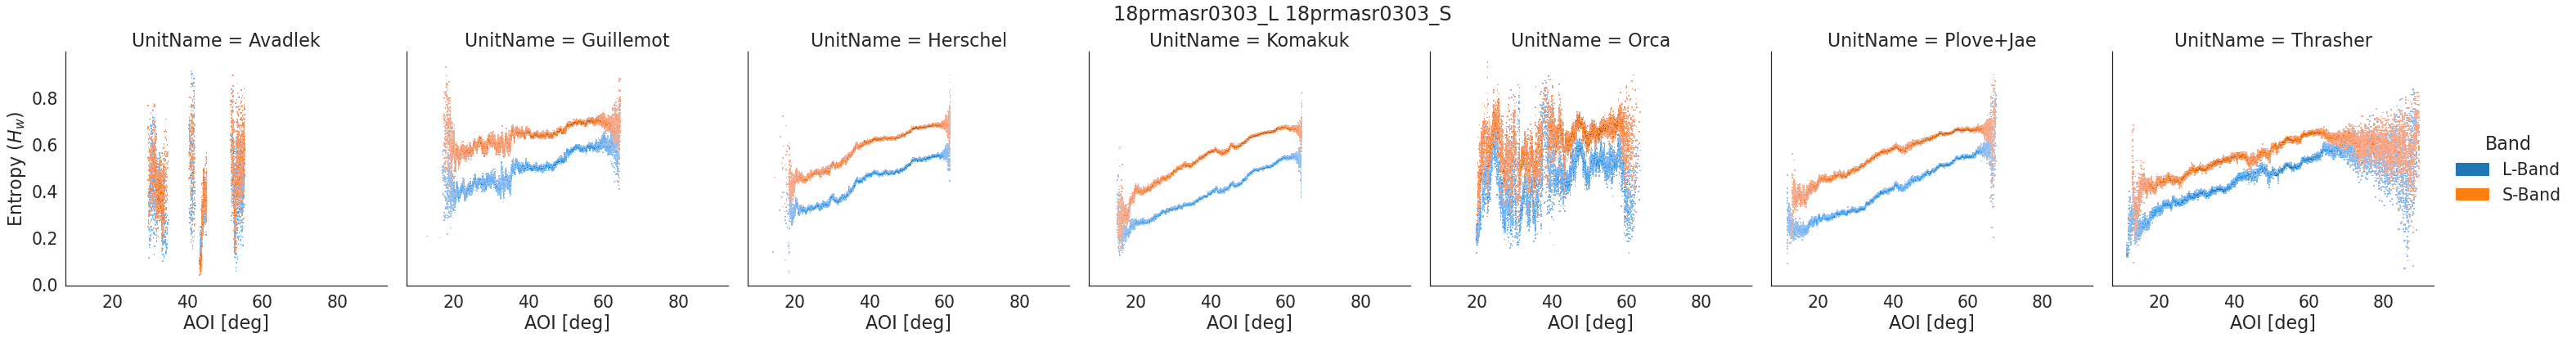

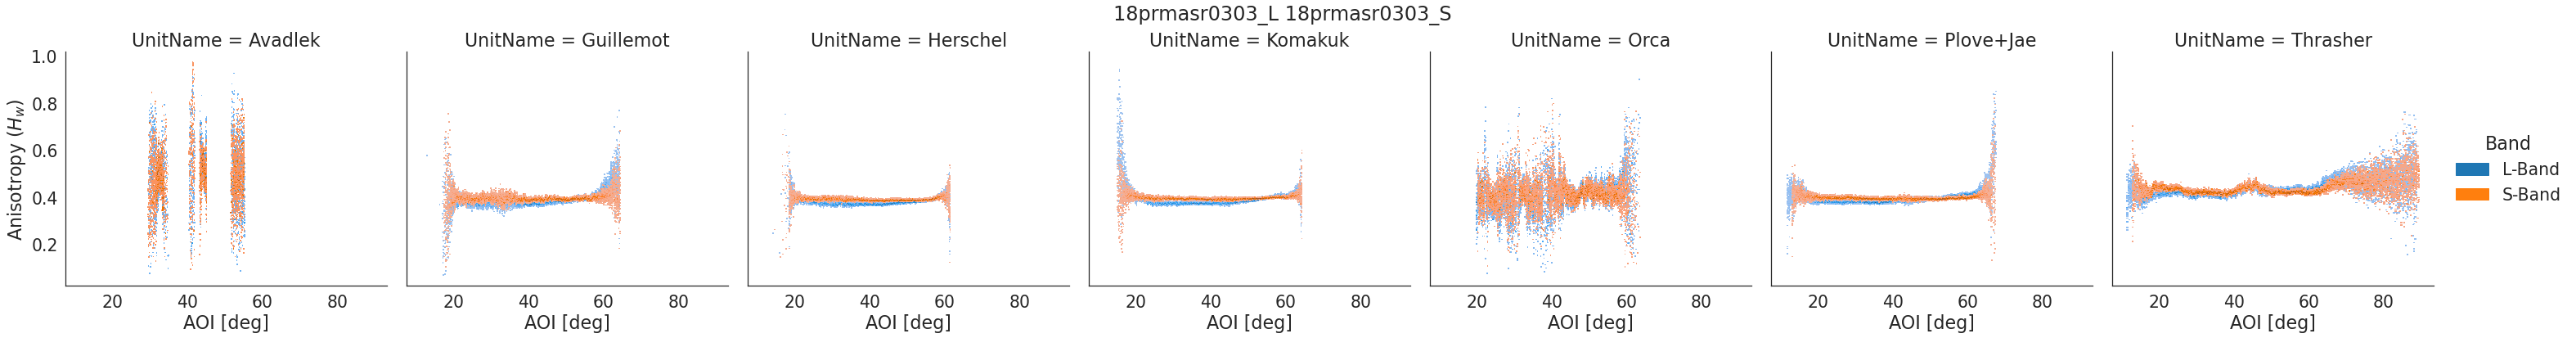

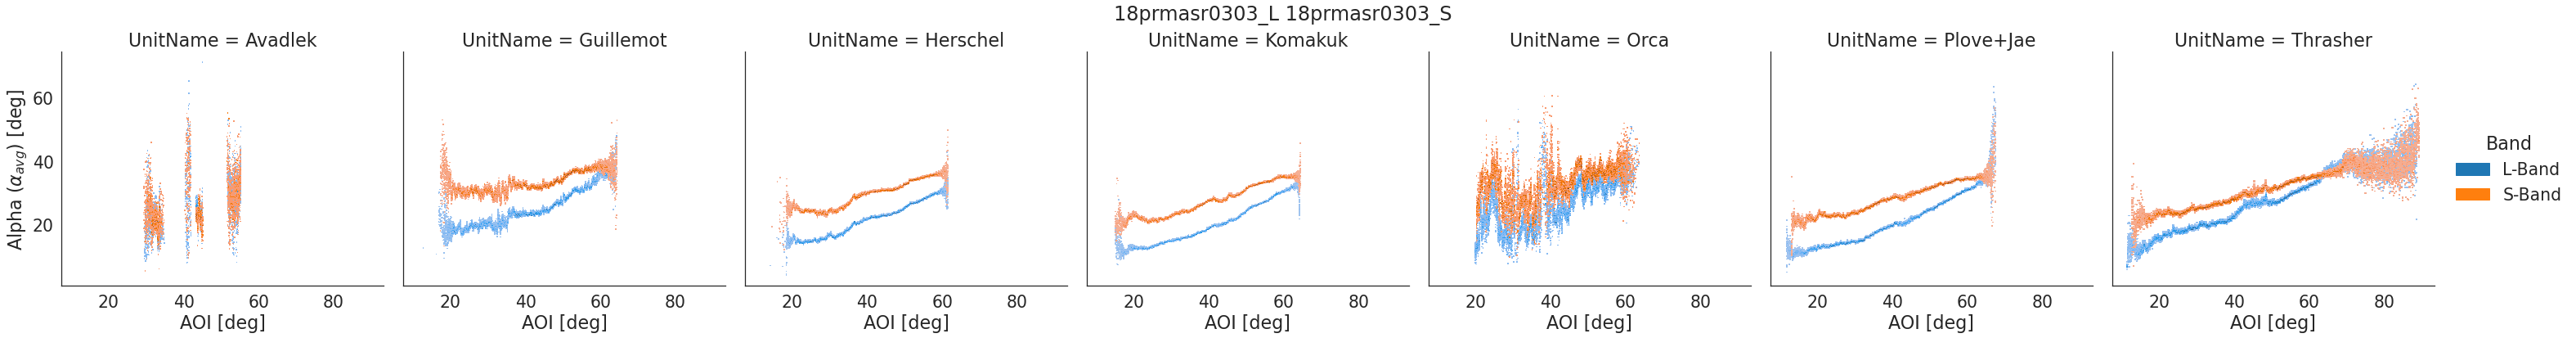

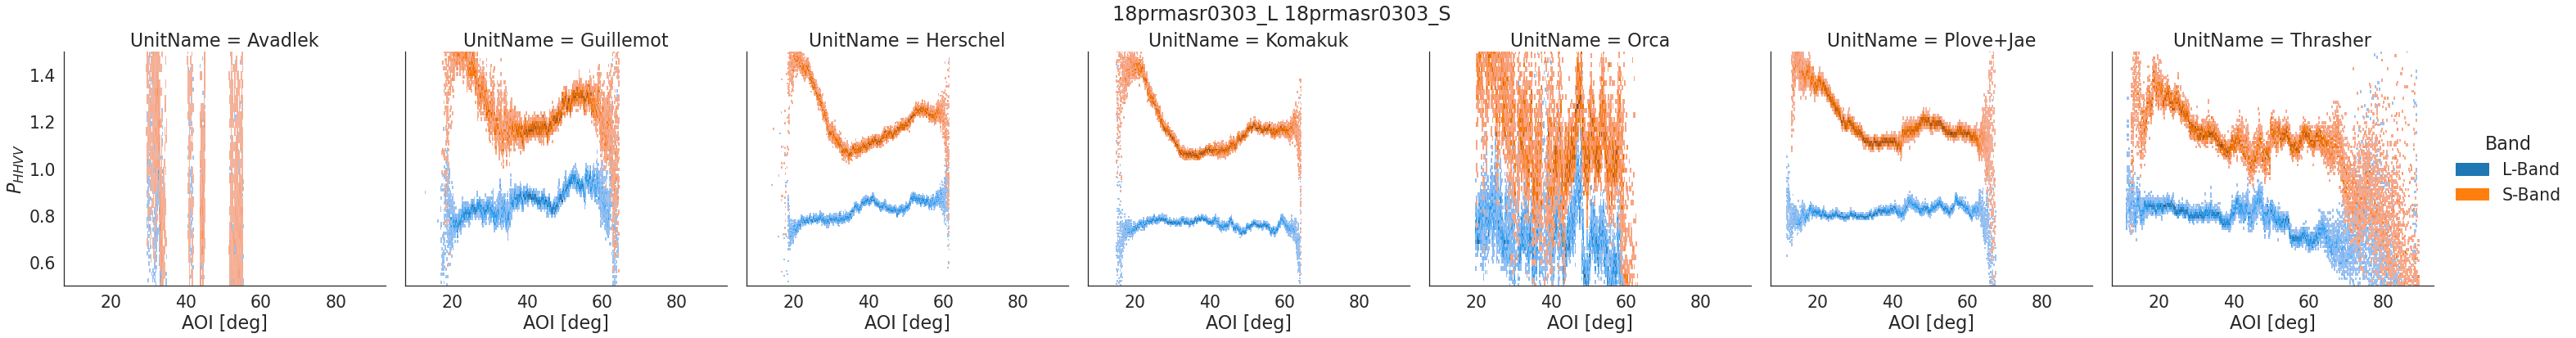

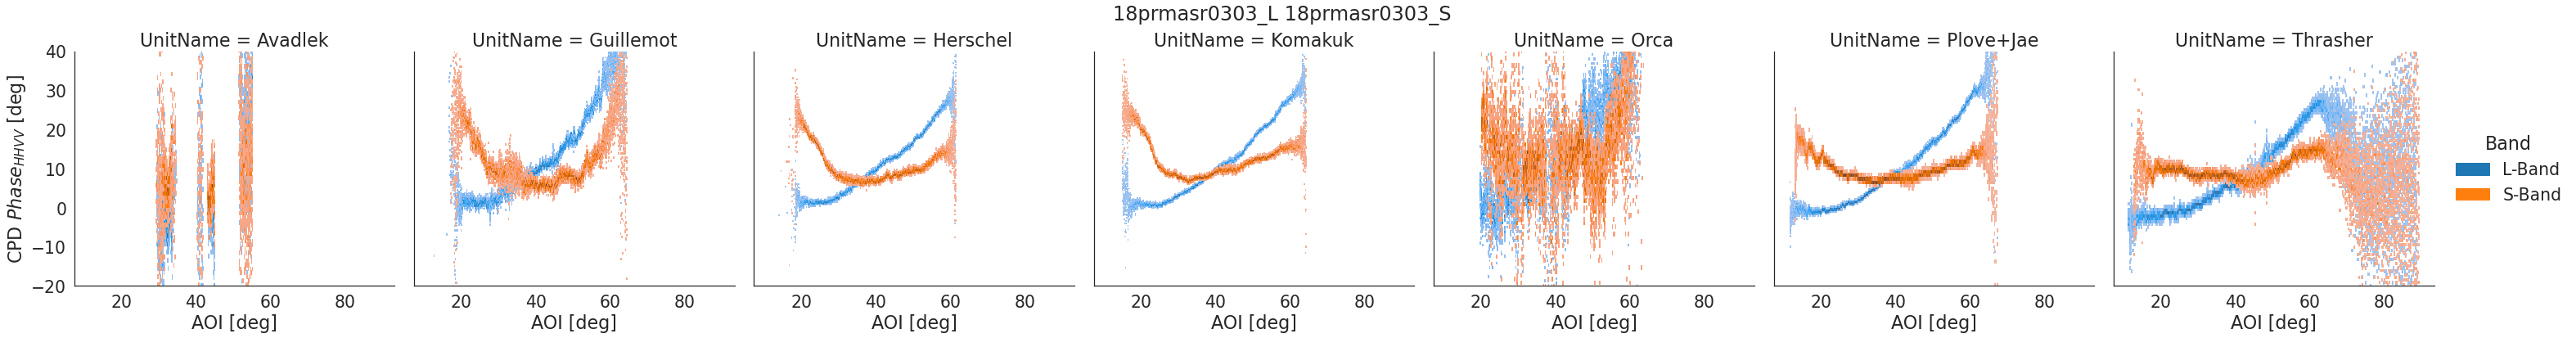

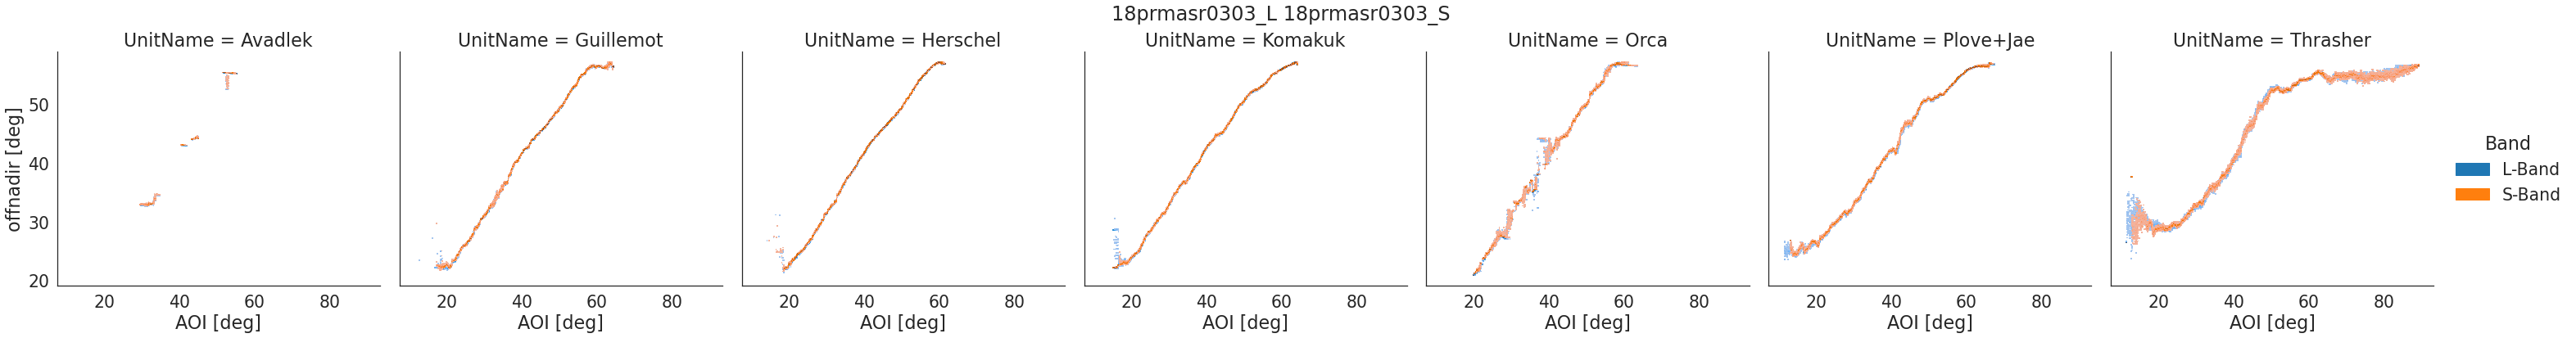

In [172]:
latex_label = {'entropy': 'Entropy (${H}_w$)', 
               'offnadir': 'offnadir [deg]',
               'anisotropy': 'Anisotropy (${H}_w$)', 
               'alpha': 'Alpha (${\\alpha}_{avg}$) [deg]',
               'p_hhvv': '${P}_{HHVV}$',
               'ph_diff_hhvv': 'CPD ${Phase}_{HHVV}$ [deg]',
               'aoi': 'AOI [deg]',}


pol_key = ['entropy', 'anisotropy', 'alpha', 'p_hhvv', 'ph_diff_hhvv', 'aoi', 'offnadir']
pol_key

x_hist= 'aoi' #x_hist


for item in pol_key:
    print(item)
    if x_hist != item:
        file_name = prmasr_nc["L"]["18"][1].name[:-3] + " " + prmasr_nc["S"]["18"][1].name[:-3]
        pol_key_name = item
        if pol_key_name == "p_hhvv":
            ylim=(0.5, 1.5)
        elif pol_key_name == "ph_diff_hhvv":
            ylim=(-20, 40)
        else:
            ylim=None

        print('Save Figure')
        fig = plot_2dhist_sns_range_profile(df=dfmean_18, 
                         x_hist=x_hist, y_hist=pol_key_name, ylim=ylim, suptitle=file_name,
                        col='UnitName', hue='band', x_y_label_dict=latex_label)


        fig.savefig(fig_save.joinpath('PNG', "range_profile", file_name + "_" +
                                      x_hist + '-' +  pol_key_name + ".png"))

/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


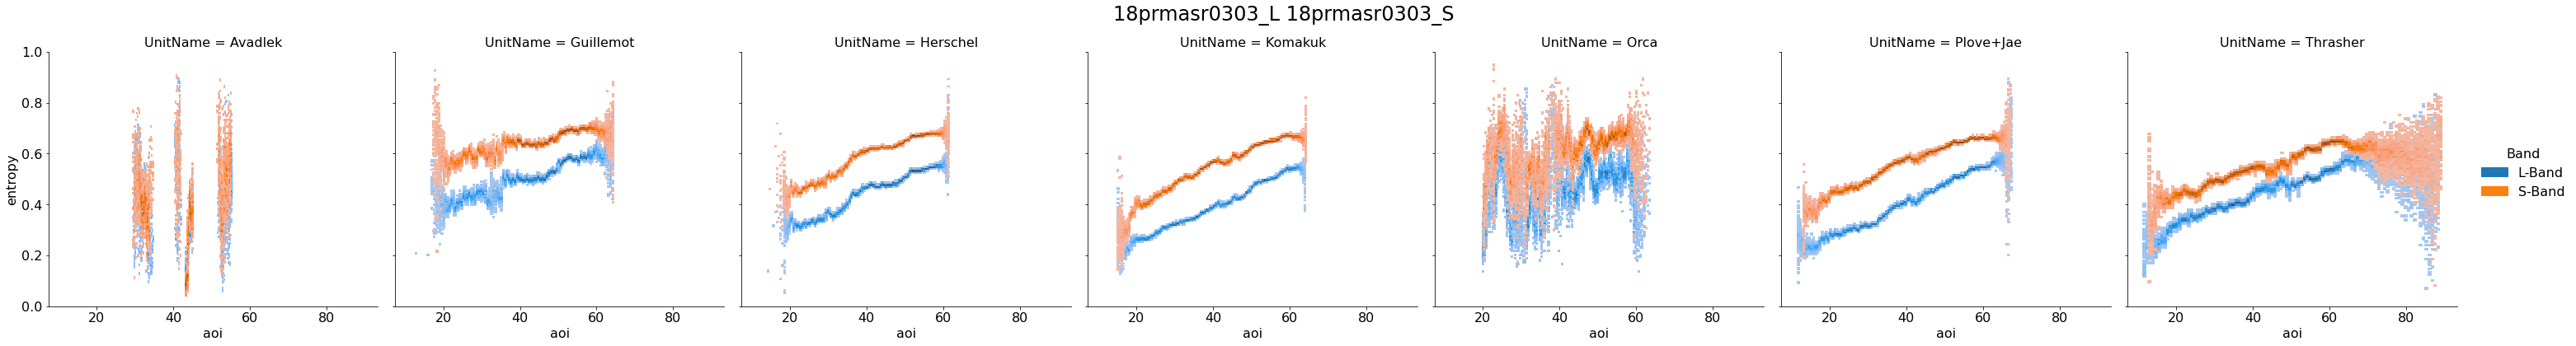

In [164]:
g = sns.FacetGrid(data=dfmean_18, col="UnitName", hue="band", height=6, ylim=(0, 1), 
                  ) 
g.map_dataframe(sns.histplot, "aoi", "entropy", bins=100, )

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle(prmasr_nc["L"]["18"][1].name[:-3] + " " + prmasr_nc["S"]["18"][1].name[:-3],
                  fontsize=24, fontdict={"weight": "bold"})


legend_name  = ['L-Band', 'S-Band',]
LegendElement = {}
LegendElement[legend_name[0]] = mpatches.Patch(color=sns.color_palette("tab10",2)[0], label=legend_name[0])
LegendElement[legend_name[1]] = mpatches.Patch(color=sns.color_palette("tab10",2)[1], label=legend_name[1])

legend_items = []

[legend_items.append(x) for x in list(dict(sorted(LegendElement.items())).values())]



g.add_legend(title="Band", handles=legend_items )

Text(0.5, 0.98, '18prmasr0303_L 18prmasr0303_S')

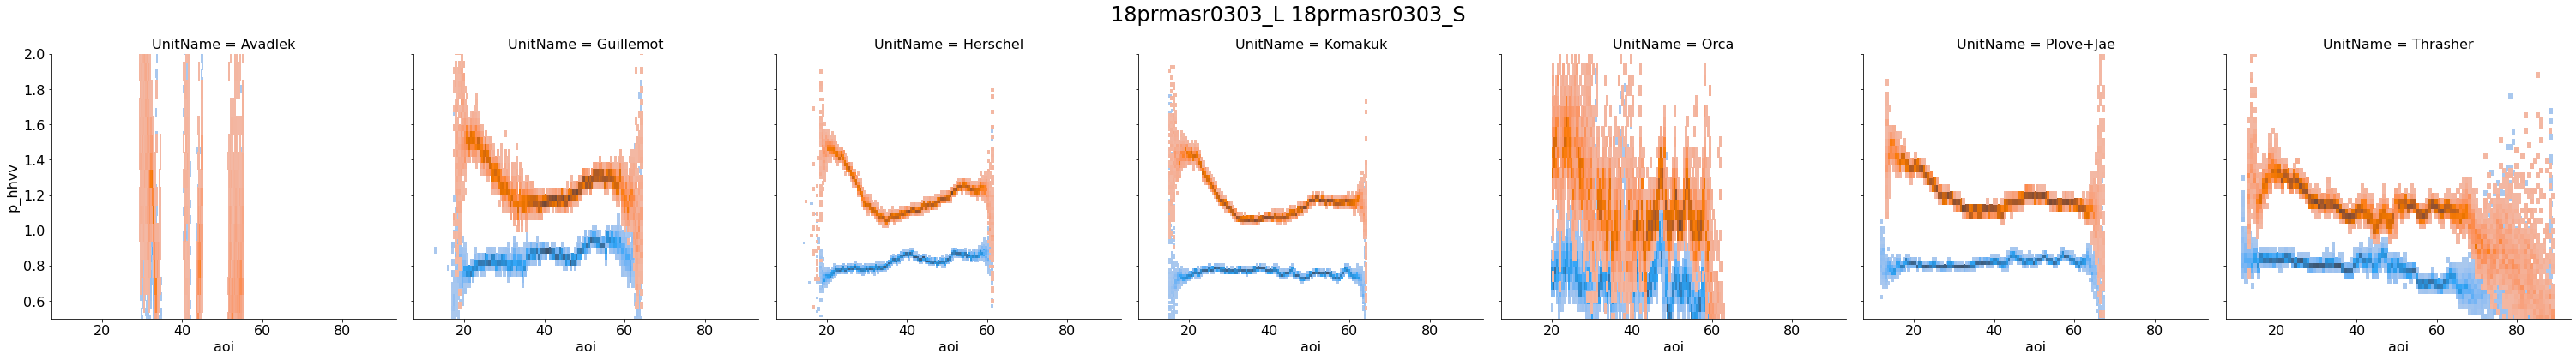

In [93]:
g = sns.FacetGrid(data=dfmean_18, col="UnitName", hue="band", height=6, ylim=(0.5, 2), 
                  ) 
g.map(sns.histplot, "aoi", "p_hhvv", bins=100)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle(prmasr_nc["L"]["18"][1].name[:-3] + " " + prmasr_nc["S"]["18"][1].name[:-3],
                  fontsize=24, fontdict={"weight": "bold"})
g.add_legend(title="Band",)

Text(0.5, 0.98, '18prmasr0303_L 18prmasr0303_S')

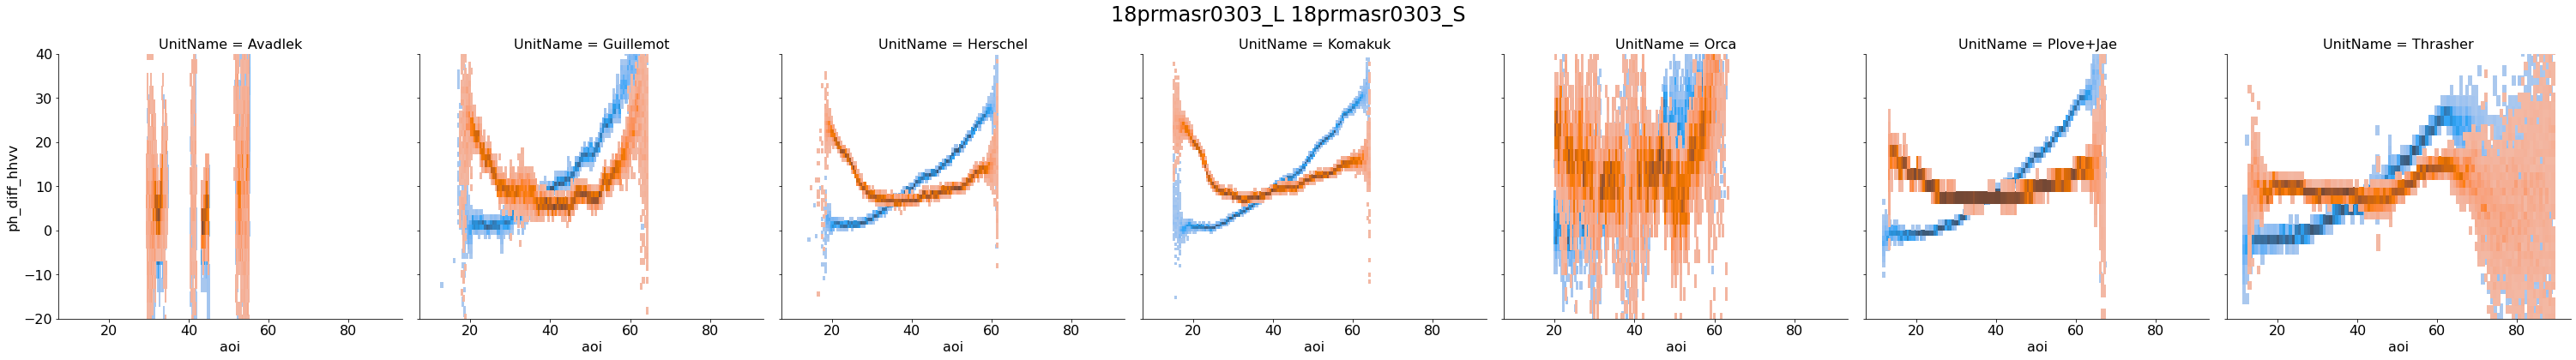

In [94]:
g = sns.FacetGrid(data=dfmean_18, col="UnitName", hue="band", height=6, ylim=(-20, 40), 
                  ) 
g.map(sns.histplot, "aoi", "ph_diff_hhvv", bins=100)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle(prmasr_nc["L"]["18"][1].name[:-3] + " " + prmasr_nc["S"]["18"][1].name[:-3],
                  fontsize=24, fontdict={"weight": "bold"})

In [75]:
df_masked_dropna_2019_mean['aoi']['mean'].values

array([18.567118, 18.573986, 18.579815, ..., 61.50092 , 61.50341 ,
       61.509647], dtype=float32)

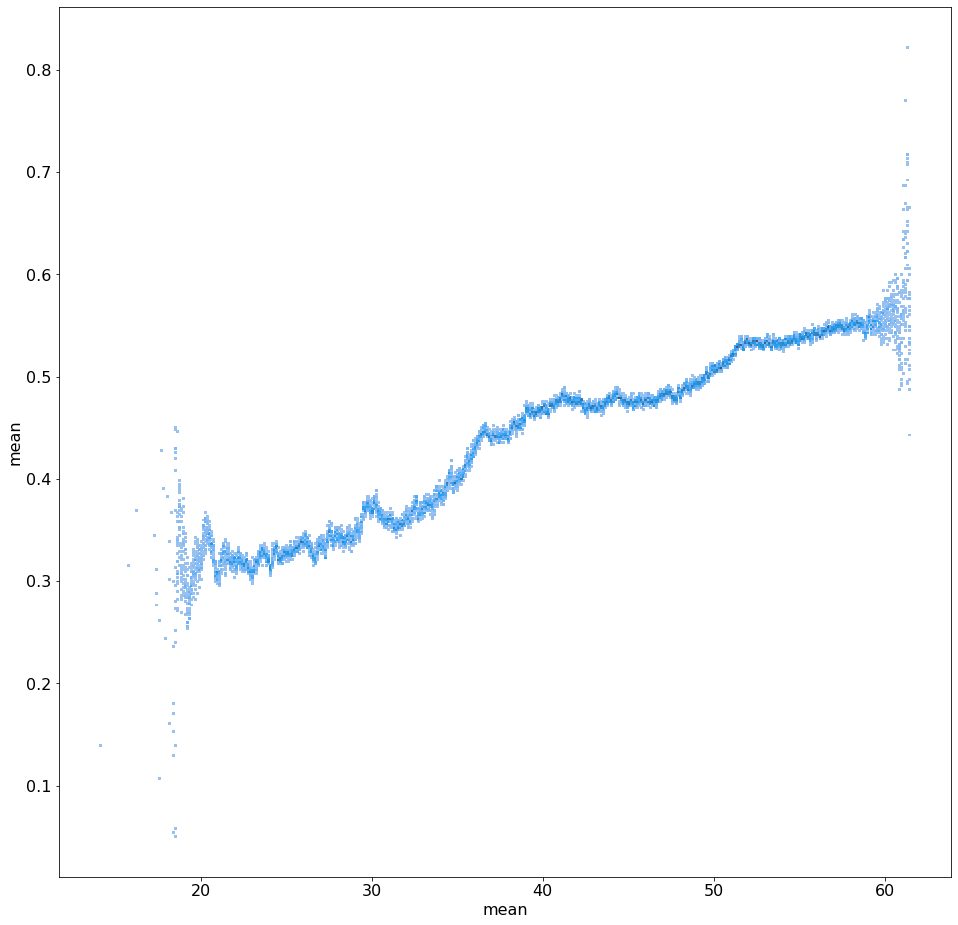

In [72]:
g = sns.histplot( x=df_masked_dropna_2018_mean.reset_index()["aoi"]["mean"], y=df_masked_dropna_2018_mean.reset_index()["entropy"]["mean"], bins=400)

In [53]:
df_masked_dropna.iloc[df_masked_dropna.index.get_level_values('time') == 2018]

offnadir   entropy  anisotropy  \
band time x             y                                               
1    2018 570017.822886 7.723698e+06  22.797363  0.427967    0.296807   
                        7.723697e+06  22.796772  0.426735    0.336659   
          570018.822886 7.723700e+06  22.810383  0.401885    0.227113   
                        7.723699e+06  22.809879  0.532011    0.176261   
                        7.723698e+06  22.809319  0.434673    0.316430   
...                                         ...       ...         ...   
          575085.822886 7.714978e+06  56.890297  0.630821    0.509478   
                        7.714977e+06  56.889950  0.655481    0.545184   
                        7.714976e+06  56.889599  0.602897    0.655921   
                        7.714975e+06  56.889256  0.502144    0.571129   
                        7.714974e+06  56.888916  0.419246    0.367556   

                                          alpha    p_hhvv  ph_diff_hhvv  \
band time x             y                                                 
1    2018 570017.822886 7.723698e+06  19.792583  0.759275      9.050803   
                        7.723697e+06  22.852973  0.684825     10.859898   
          570018.822886 7.723700e+06  16.621316  0.942100     -7.476103   
                        7.723699e+06  21.654459  0.897151     -0.029181   
                        7.723698e+06  19.845599  0.761683      9.250571   
...                                         ...       ...           ...   
          575085.822886 7.714978e+06  31.569770  0.771896     28.170963   
                        7.714977e+06  35.813449  0.578741     36.293770   
                        7.714976e+06  37.599367  0.373519     35.668659   
                        7.714975e+06  33.532269  0.437424     28.808884   
                        7.714974e+06  38.263611  0.343791     28.436739   

                                            aoi  mask_valid  mask_Avadlek  \
band time x             y                                                   
1    2018 570017.822886 7.723698e+06  21.129635           1             0   
                        7.723697e+06  21.128956           1             0   
          570018.822886 7.723700e+06  21.176111           1             0   
                        7.723699e+06  21.178421           1             0   
                        7.723698e+06  21.179407           1             0   
...                                         ...         ...           ...   
          575085.822886 7.714978e+06  56.596546           1             0   
                        7.714977e+06  56.564789           1             0   
                        7.714976e+06  56.534359           1             0   
                        7.714975e+06  56.505287           1             0   
                        7.714974e+06  56.477287           1             0   

                                      mask_Guillemot  mask_Herschel  \
band time x             y                                             
1    2018 570017.822886 7.723698e+06               0              1   
                        7.723697e+06               1              1   
          570018.822886 7.723700e+06               0              1   
                        7.723699e+06               0              1   
                        7.723698e+06               0              1   
...                                              ...            ...   
          575085.822886 7.714978e+06               0              1   
                        7.714977e+06               0              1   
                        7.714976e+06               0              1   
                        7.714975e+06               0              1   
                        7.714974e+06               0              1   

                                      mask_Komakuk  mask_Orca  \
band time x             y                                       
1    2018 570017.822886 7.723698e+06             0       

In [30]:
bins = pd.cut(df_masked_dropna['aoi'], [0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

bins

band  time  x              y           
1     2018  570017.822886  7.723698e+06    (20, 30]
                           7.723697e+06    (20, 30]
            570018.822886  7.723700e+06    (20, 30]
                           7.723699e+06    (20, 30]
                           7.723698e+06    (20, 30]
                                             ...   
      2019  575087.822886  7.714978e+06    (50, 60]
                           7.714977e+06    (50, 60]
                           7.714976e+06    (50, 60]
                           7.714975e+06    (50, 60]
                           7.714974e+06    (50, 60]
Name: aoi, Length: 28253194, dtype: category
Categories (9, interval[int64]): [(0, 10] < (10, 20] < (20, 30] < (30, 40] ... (50, 60] < (60, 70] < (70, 80] < (80, 90]]

In [31]:
df_masked_dropna.groupby(bins).agg(['count', 'sum', 'mean'])

offnadir                 entropy               anisotropy  \
             count           sum     count           sum      count   
aoi                                                                   
(0, 10]          0  0.000000e+00         0  0.000000e+00          0   
(10, 20]     27370  6.092959e+05     27370  8.186967e+03      27370   
(20, 30]   3240705  8.724229e+07   3240705  9.879967e+05    3240705   
(30, 40]   5133157  1.921315e+08   5133157  1.833366e+06    5133157   
(40, 50]   9780445  4.474557e+08   9780445  3.942180e+06    9780445   
(50, 60]  10042712  5.339042e+08  10042712  4.559874e+06   10042712   
(60, 70]     28805  1.642145e+06     28805  1.404389e+04      28805   
(70, 80]         0  0.000000e+00         0  0.000000e+00          0   
(80, 90]         0  0.000000e+00         0  0.000000e+00          0   

                           alpha                  p_hhvv                ...  \
                   sum     count           sum     count           sum  ...   
aoi                                                                     ...   
(0, 10]   0.000000e+00         0  0.000000e+00         0  0.000000e+00  ...   
(10, 20]  1.250394e+04     27370  4.065615e+05     27370  1.930890e+04  ...   
(20, 30]  1.354450e+06   3240705  4.634834e+07   3240705  2.471374e+06  ...   
(30, 40]  1.976716e+06   5133157  8.365825e+07   5133157  4.196424e+06  ...   
(40, 50]  3.757893e+06   9780445  1.842501e+08   9780445  8.349610e+06  ...   
(50, 60]  4.081118e+06  10042712  2.245808e+08  10042712  8.808759e+06  ...   
(60, 70]  1.233976e+04     28805  7.189288e+05     28805  2.560659e+04  ...   
(70, 80]  0.000000e+00         0  0.000000e+00         0  0.000000e+00  ...   
(80, 90]  0.000000e+00         0  0.000000e+00         0  0.000000e+00  ...   

         mask_Orca         mask_Plove_+Jae          mask_Thrasher          \
             count     sum           count      sum         count     sum   
aoi                                                                         
(0, 10]          0     0.0               0      0.0             0     0.0   
(10, 20]     27370     0.0           27370     88.0         27370     0.0   
(20, 30]   3240705  1108.0         3240705  14859.0       3240705   637.0   
(30, 40]   5133157  1799.0         5133157  35889.0       5133157  1080.0   
(40, 50]   9780445  7007.0         9780445  32301.0       9780445   415.0   
(50, 60]  10042712  4646.0        10042712  49999.0      10042712   532.0   
(60, 70]     28805     0.0           28805    496.0         28805     0.0   
(70, 80]         0     0.0               0      0.0             0     0.0   
(80, 90]         0     0.0               0      0.0             0     0.0   

         wavelength               spatial_ref      
              count           sum       count sum  
aoi                                                
(0, 10]           0  0.000000e+00           0   0  
(10, 20]      27370  6.191139e+03       27370   0  
(20, 30]    3240705  7.330520e+05     3240705   0  
(30, 40]    5133157  1.161127e+06     5133157   0  
(40, 50]    9780445  2.212350e+06     9780445   0  
(50, 60]   10042712  2.271675e+06    10042712   0  
(60, 70]      28805  6.515731e+03       28805   0  
(70, 80]          0  0.000000e+00           0   0  
(80, 90]          0  0.000000e+00           0   0  

[9 rows x 34 columns]

In [33]:
df_mean = (df_masked_dropna
      .assign(Bin=lambda x: pd.cut(x.aoi, bins=100))
      .groupby(['Bin'])
      .agg(['mean', 'count'])
     )

df_mean

offnadir          entropy        anisotropy         \
                       mean  count      mean  count       mean  count   
Bin                                                                     
(13.997, 14.52]   26.697531      1  0.138550      1   0.247463      1   
(14.52, 14.995]         NaN      0       NaN      0        NaN      0   
(14.995, 15.469]        NaN      0       NaN      0        NaN      0   
(15.469, 15.944]  27.315413      1  0.316184      1   0.164437      1   
(15.944, 16.419]  31.139029      1  0.370035      1   0.413798      1   
...                     ...    ...       ...    ...        ...    ...   
(59.152, 59.627]  56.925156  94460  0.477774  94460   0.430406  94460   
(59.627, 60.102]  57.059917  45086  0.479967  45086   0.429764  45086   
(60.102, 60.577]  57.033829  15661  0.489291  15661   0.424631  15661   
(60.577, 61.052]  56.911831   5434  0.481883   5434   0.437652   5434   
(61.052, 61.526]  56.863136   1115  0.502041   1115   0.423367   1115   

                      alpha           p_hhvv         ... mask_Orca         \
                       mean  count      mean  count  ...      mean  count   
Bin                                                  ...                    
(13.997, 14.52]    7.198995      1  0.927778      1  ...       0.0      1   
(14.52, 14.995]         NaN      0       NaN      0  ...       NaN      0   
(14.995, 15.469]        NaN      0       NaN      0  ...       NaN      0   
(15.469, 15.944]  15.920588      1  0.711195      1  ...       0.0      1   
(15.944, 16.419]  15.600086      1  1.152705      1  ...       0.0      1   
...                     ...    ...       ...    ...  ...       ...    ...   
(59.152, 59.627]  24.630877  94460  0.890478  94460  ...       0.0  94460   
(59.627, 60.102]  24.820845  45086  0.884812  45086  ...       0.0  45086   
(60.102, 60.577]  25.023236  15661  0.883065  15661  ...       0.0  15661   
(60.577, 61.052]  24.655870   5434  0.918071   5434  ...       0.0   5434   
(61.052, 61.526]  25.080239   1115  0.898810   1115  ...       0.0   1115   

                 mask_Plove_+Jae        mask_Thrasher        wavelength  \
                            mean  count          mean  count       mean   
Bin                                                                       
(13.997, 14.52]         0.000000      1           0.0      1   0.226208   
(14.52, 14.995]              NaN      0           NaN      0        NaN   
(14.995, 15.469]             NaN      0           NaN      0        NaN   
(15.469, 15.944]        0.000000      1           0.0      1   0.226208   
(15.944, 16.419]        0.000000      1           0.0      1   0.226208   
...                          ...    ...           ...    ...        ...   
(59.152, 59.627]        0.009464  94460           0.0  94460   0.226201   
(59.627, 60.102]        0.009826  45086           0.0  45086   0.226201   
(60.102, 60.577]        0.018837  15661           0.0  15661   0.226201   
(60.577, 61.052]        0.013618   5434           0.0   5434   0.226201   
(61.052, 61.526]        0.000000   1115           0.0   1115   0.226201   

                        spatial_ref         
                  count        mean  count  
Bin                                         
(13.997, 14.52]       1         0.0      1  
(14.52, 14.995]       0         NaN      0  
(14.995, 15.469]      0         NaN      0  
(15.469, 15.944]      1         0.0      1  
(15.944, 16.419]      1         0.0      1  
...                 ...         ...    ...  
(59.152, 59.627]  94460         0.0  94460  
(59.627, 60.102]  45086         0.0  45086  
(60.102, 60.577]  15661         0.0  15661  
(60.577, 61.052]   5434         0.0   5434  
(61.052, 61.526]   1115         0.0   1115  

[100 rows x 34 columns]

In [40]:
df_mean.reset_index()["offnadir"]["mean"]

0     26.697531
1           NaN
2           NaN
3     27.315413
4     31.139029
        ...    
95    56.925156
96    57.059917
97    57.033829
98    56.911831
99    56.863136
Name: mean, Length: 100, dtype: float32

<AxesSubplot:xlabel='mean', ylabel='mean'>

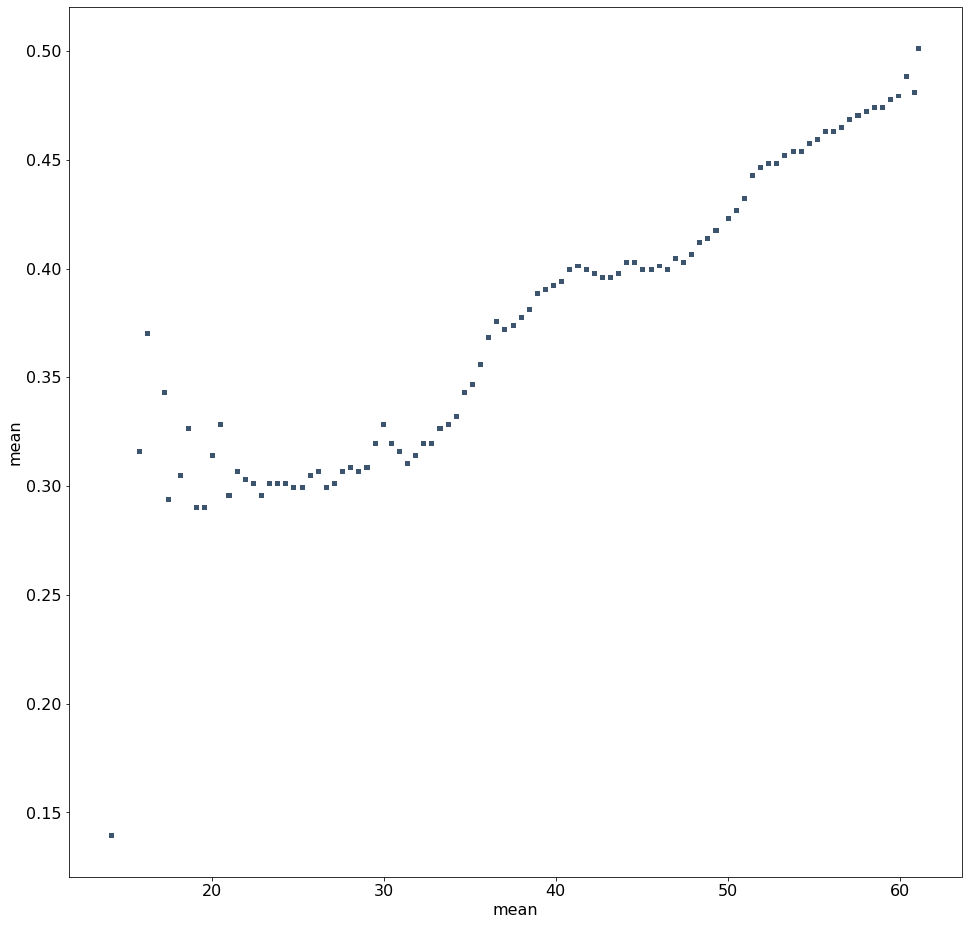

In [45]:
sns.histplot( x=df_mean.reset_index()["aoi"]["mean"], y=df_mean.reset_index()["entropy"]["mean"], bins=200)

AttributeError: 'QuadMesh' object has no property 'size'

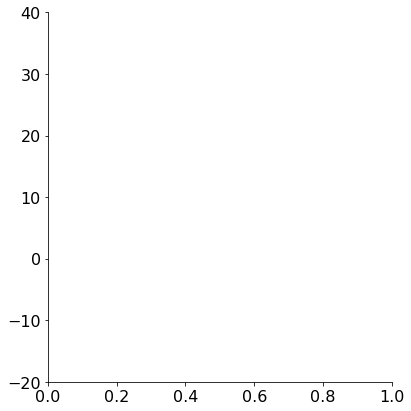

In [37]:
g = sns.FacetGrid(data=df_mean,  height=6, ylim=(-20, 40)) # col="time",  row="sex",
g.map(sns.histplot, "aoi", "ph_diff_hhvv", bins=100)

In [ ]:
df_mean = (df_masked_dropna.dropna()
      .assign(Bin=lambda x: pd.cut(x.Value, bins=100))
      .groupby(['Bin'])
      .agg({'Value': ['mean', 'count']})
     )

In [10]:
df_test = pd.DataFrame(np.random.randn(1000), columns=['Value'])
df_test

,Value
0,-0.594363
1,-1.102543
2,2.371818
3,-1.362019
4,0.502956
...,...
995,0.058085
996,0.787806
997,0.133420
998,-0.665119


In [13]:
df = (df_test
      .assign(Bin=lambda x: pd.cut(x.Value, bins=100))
      .groupby(['Bin'])
      .agg({'Value': ['mean', 'count']})
     )
df

Value      
                      mean count
Bin                             
(-3.099, -3.036] -3.093277     1
(-3.036, -2.978]       NaN     0
(-2.978, -2.92]  -2.973878     1
(-2.92, -2.862]        NaN     0
(-2.862, -2.805]       NaN     0
...                    ...   ...
(2.391, 2.449]    2.413002     2
(2.449, 2.507]    2.467696     2
(2.507, 2.564]    2.523237     3
(2.564, 2.622]         NaN     0
(2.622, 2.68]     2.659346     2

[100 rows x 2 columns]

In [9]:
df = (pd.DataFrame(np.random.randn(1000), columns=['Value'])
      .assign(Bin=lambda x: pd.cut(x.Value, bins=10))
      .groupby(['Bin'])
      .agg({'Value': ['sum', 'count']})
     )